# Tutorial for fitting neural calcium imaging data with GLM
-----------
This is a tutorial for fitting generalized linear models (GLM) on calcium imaging data recorded from a mouse performing a decision-making task in virtual maze. You need to have the script `glm_class.py` that contains the code for the GLM class definitions and utility functions, which we will import as a module later. You also need the data file `example_data_glm.pkl` (23.7 MB) in your local directory that you can load into the workspace. 

The tutorial will walk you through steps including (1) data exploration and visualization, (2) building design matrix with basis expansion, (3) model fitting and evalutaion, as well as (4) different ways to quantify the contribution/importance of various features, such as external experimental conditions or the animal's behavioral responses. It assumes that you are familiar with basic model fitting procedures using the GLM class. If not, please go to the iPython notebook `Tutorial_for_using_GLM_class.ipynb` first, or see the documentation in the file `glm_class.py` for more details.

The code for fitting GLM works most efficiently on a GPU. If you are using Google Colab, please go to *Runtime -> Change runtime type*, and and make sure *GPU* is selected under *Hardware accelerator*.

*Created by Shih-Yi Tseng from the Harvey Lab at Harvard Medical School*

*Last updated: 9/5/2022*

## Section 0: Preparation


### Import library

In [1]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import SplineTransformer, QuantileTransformer
import tensorflow as tf
import pickle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import code for GLM class

Here, if in Google Colab, you can manually create a folder called *src*, put the file *glm_class.py* into that folder, and then import it as a module.

In [2]:
# Import src/glm_class.py as a module called glm
import src.glm_class as glm

Alternatively, on your local computer or cluster, you may have file *glm_class.py* saved in a different folder. You have to add the path of the folder to your system path before importing it. 

```
import sys
sys.path.append("PATH_TO_THE_FOLDER")
import glm_class as glm
```

### Tensorflow and GPU related checks

Check tensorflow version, eager execution state (has to be *True*) and GPU availability.

In [ ]:
# Check version and eager execution state
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

# Get available devices
devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.8.2
keras version 2.8.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Check GPU type (for Colab)
!nvidia-smi

Tue Sep  6 02:07:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    286MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

When fitting the models to large dataset on GPUs of your local computer or cluster, if you encounter memory issue, try to limit GPU memory growth by using `tf.config.experimental.set_memory_growth` or directly limit the allocated memory using `tf.config.set_logical_device_configuration`. See Tensorflow documentation for these two functions:

https://www.tensorflow.org/api_docs/python/tf/config/experimental/set_memory_growth

https://www.tensorflow.org/api_docs/python/tf/config/set_logical_device_configuration

## Section 1: Explore the data

### Section 1.1: Dataset description

The data in `example_data_glm.pkl` came from two-photon calcium imaging of mouse retrosplenial cortex (RSC) during a navigation-based decision-making task (from Tseng *et al.* 2022; see schematic below). The mouse ran down a virtual Y-maze and used visual cues on the wall to guide its choice into one of the two maze arms. After the reaching the end of the arm, the mouse was presented with a feedback delay, followed by a visual feedback indicating the correctness of its choice, and then received reward for correct trials or entered inter-trial intervals for incorrect trials (shown in **B**). The rewarded associations between cue and choice are determined by two rules (rule A or rule B as indicated in **A**), and the rule swicthed in blocks of 100-175 trials without explicit signaling multiple times within a single session. The mouse's performance usually dropped below chance level (fraction correct < 0.5) and recovered to expert level after 30-50 trials after rule switches (shown in **C**).

In the session, we recorded activities from multiple neurons using two-photon calcium imaging. The goal is to use generalized linear models (GLMs) to relate the activity of individual neurons to different sensory, motor and cognitive variables relevant for the tasks, such as cue identity, running velocity, the animal's choice, etc.


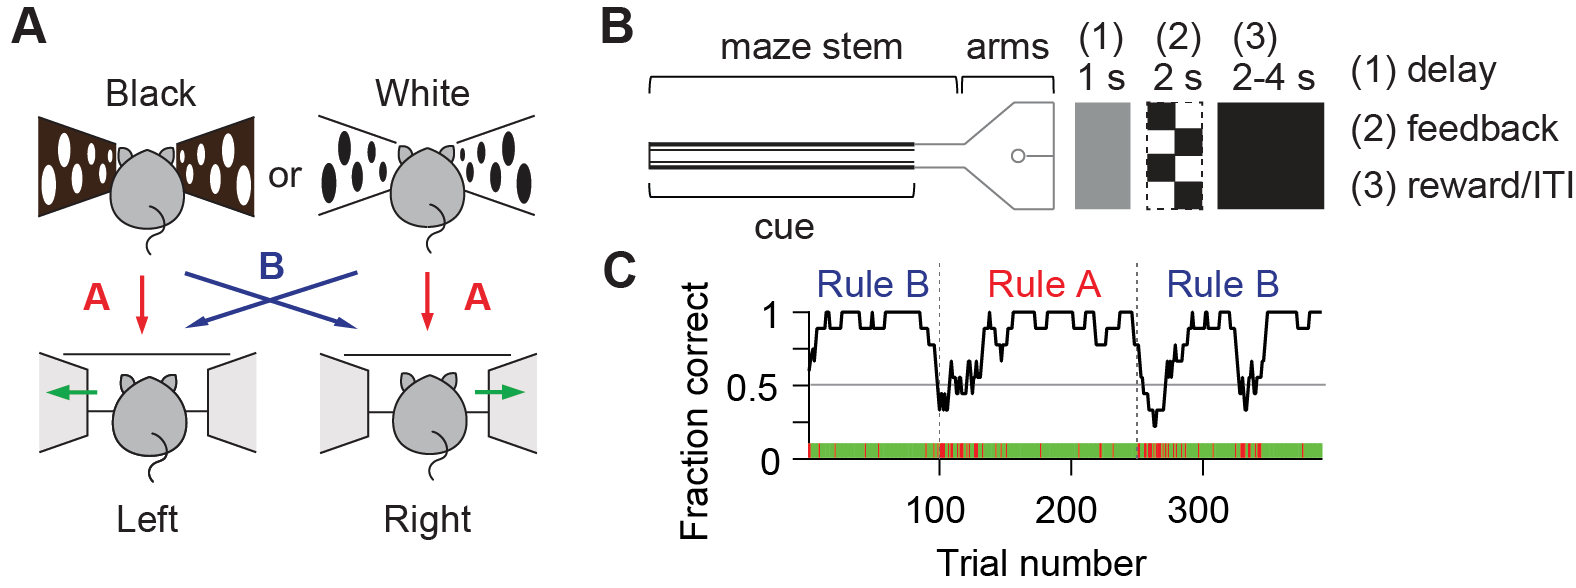

#### Load data

Put data file `example_data_glm.pkl` (23.7 MB) in your local directory (for example, here I'm putting it in a folder call `data`), and load it with pickle.

In [3]:
# Load the file and check data type
with open('data/example_data_glm.pkl', 'rb') as file:
    data = pickle.load(file)
print(type(data))

<class 'dict'>


All data is contained in this Python dictionary. Let's examine the keys.

In [ ]:
# Examine keys in data
data.keys()

dict_keys(['deconv', 'trial_num', 'time_from_cho', 'posF', 'task_var', 'movement_var'])

#### Structure of the data
Here is the description of each key:

- `deconv`: deconvolved activity of 100 neurons sampled at 6 Hz; ndarray of shape (n_timepoints, n_neurons). 

- `trial_num`: the trial number of each timepoint; ndarray of shape (n_timepoints, ).

- `posF`: mouse's forward position in the virtual Y-maze ranging from 10 to 250 a.u.; ndarray of shape (n_timepoints, ). Unit 10-200: maze stem, unit 200: Y-intersection; unit 200-250: maze arms. Occasionally the mouse went backward so there are a few points with positions < 10. Timepoints in feedback/ITI are NaNs.

- `time_from_cho`: time elapsed (in sec) after the mouse reached the end of the maze. t < 0: maze traversal; 0 < t < 1: feedback delay; 1 < t < 3: visual feedback for correctness; 3 < t < 5: reward/ITI.

- `task_var`: dictionary containing task variables listed below; each variable is an ndarray of shape (n_timepoints, ).
  - `cue`, `cho`, `corr`, `prevCorr`: binary variables for the cue identity, the mouse's reported choice, the outcome of the current trial and one previous trial. Cue: white (-0.5) vs. black (0.5); choice: right (-0.5) vs. left (0.5); outcome and previous outcome: correct (0.5) vs. incorrect (-0.5), with previous outcome of the first trial set to 0. In the given data, these variables are zero-centered, so instead of 1 or 0, the values are actually 0.5 or -0.5. 
  - `rule_following`, `bias_following`, `belief`: strategy variables describing how much on each trial the mouse was following a specific rule, how much it was biased towards a specific choice, and the strength and directionality of the rule belief, respectively. `rule_following` and `bias_following` bounded between -0.5 to 0.5, whereas the values of `belief` has been z-scored since we normally have uneven number of rule blocks. See Tseng *et al.* (2022) for more details.
  - `dyn_cho`: dynamic choice of the mouse. A continous estimate of the choice at each timepoints, modeled from the mouse's running trajectories, which  captured the real-time dynamics of choice formation process. This value may differ from (binary) reported choice in early or mid trial as the mouse could change tis mind about its final decision while running down the maze stem. Original value from 0 (right) to 1 (left), but now zero-centered with the range from -0.5 to 0.5. See Tseng *et al.* (2022) for more details.

- `movement_var`: dictionary containing the mouse's z-scored running velocities (`pitch`, `roll`, `yaw`) on the spherical treadmill; each variable is an ndarray of shape (n_timepoints, ).

*Note that there's some discontinuity in the data. A small number of trials / imaging frames have been removed from the dataset.*

Let's check the content and shape of some of these variables.

In [ ]:
# Check shape of deconvolved activity
data['deconv'].shape
print('Number of timepoints =', data['deconv'].shape[0], '\nNumber of neurons =', data['deconv'].shape[1])

Number of timepoints = 27396 
Number of neurons = 100


In [ ]:
# Check trial number, forward position, time from choice point
print(data['trial_num'].shape, data['posF'].shape, data['time_from_cho'].shape)

(27396,) (27396,) (27396,)


In [ ]:
# Check keys in task variables
data['task_var'].keys()

dict_keys(['cue', 'cho', 'corr', 'prevCorr', 'rule_following', 'bias_following', 'belief', 'dyn_cho'])

In [ ]:
# Check shape of one of the task variables
data['task_var']['cue'].shape

(27396,)

In [ ]:
# Check keys in movement variables
data['movement_var'].keys()

dict_keys(['pitch', 'roll', 'yaw'])

In [ ]:
# Check shape of one of the movement variables
data['movement_var']['pitch'].shape

(27396,)

### Section 1.2: Visualize data


#### Data time series

Let's look at the first 1000 timepoints (166 sec) of the data.

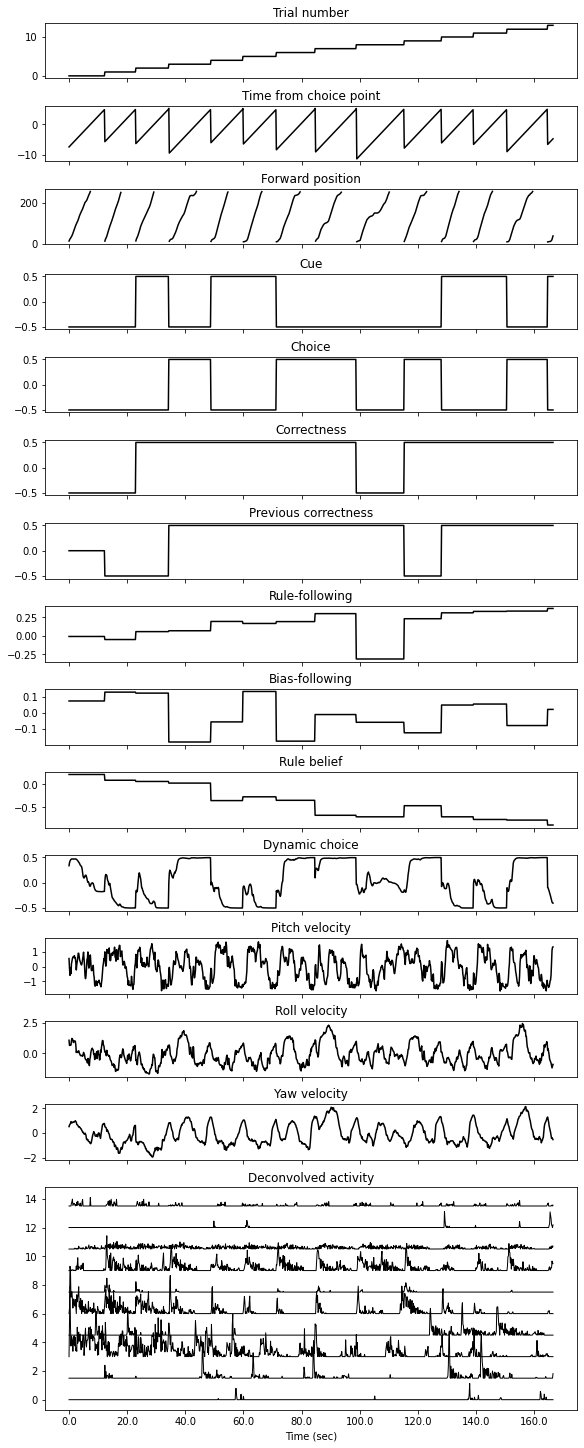

In [ ]:
# Set time period of plotting
sampling_freq_hz = 6  # 6 Hz
start_timepoint = 0
end_timepoint = 1000

# Define all variables we want to visualize
trial_var = ['trial_num', 'time_from_cho', 'posF']
task_var = list(data['task_var'].keys())
mvt_var = list(data['movement_var'].keys())
n_vars = len(trial_var)+len(task_var)+len(mvt_var)

# Set up pretty naming
trial_var_names = ['Trial number', 'Time from choice point', 'Forward position']
task_var_names = [
    'Cue',
    'Choice',
    'Correctness',
    'Previous correctness',
    'Rule-following',
    'Bias-following',
    'Rule belief',
    'Dynamic choice']
mvt_var_names = ['Pitch velocity', 'Roll velocity', 'Yaw velocity']

# Set up plot
f, ax = plt.subplots(n_vars + 1 , 1, 
                     sharex=True, figsize=(8, 20),
                     constrained_layout=True, 
                     gridspec_kw={'height_ratios': [1] * n_vars + [4]})

# Loop over basic trial variables and create plot
for i, variable in enumerate(trial_var):
    ax[i].plot(data[variable][start_timepoint:end_timepoint], 'k')
    ax[i].set_title(trial_var_names[i])

# Loop over task variables and create plot
for i, variable in enumerate(task_var):
    ax[len(trial_var)+i].plot(data['task_var'][variable][start_timepoint:end_timepoint], 'k')
    ax[len(trial_var)+i].set_title(task_var_names[i])

# Loop over movement variables and create plot
for i, variable in enumerate(mvt_var):
    ax[len(trial_var)+len(task_var)+i].plot(data['movement_var'][variable][start_timepoint:end_timepoint], 'k')
    ax[len(trial_var)+len(task_var)+i].set_title(mvt_var_names[i])

# Show deconvolved activity of the first 10 neurons
n_selected_neurons = 10
ax[-1].plot(data['deconv'][start_timepoint:end_timepoint,:n_selected_neurons] + 1.5 * np.arange(n_selected_neurons), 'k', linewidth=1)
ax[-1].set_title('Deconvolved activity')
ax[-1].set_xticks(np.arange(start_timepoint,end_timepoint,120))
ax[-1].set_xticklabels(np.arange(start_timepoint,end_timepoint,120)/sampling_freq_hz)
ax[-1].set_xlabel('Time (sec)');

#### Trial type-averaged activity

We can start at looking at one single neuron's average activity vs. position during maze traversal or time in feedback/ITI in the 4 trial types separately: black vs. white cue and left vs. right choice. Note that "black-left" means that the cue was black and that the mouse actually turned left, regardless of if turning left was correct (rule A) or incorrect (rule B). We will discretize maze position into position bins and time in feedback/ITI into time bins so we can get average neural activity for each bin.

First execute the following code block that contains the functions for binning (`pos_tm_binning`) and plotting (`plot_trial_type_activity`).

In [ ]:
def pos_tm_binning(X, posF, time_from_cho, pos_centers, pos_half_width, tm_centers, tm_half_width):
    '''
    Bin input X by positions and time

    Input parameters::
    X: variable for binning, ndarray
    posF: position for each point in X, ndarray of shape (X.shape[0],)
    time_from_cho: time from choice point for each point in X, ndarray of shape (X.shape[0],)
    pos_centers: center locations for position bins, ndarray
    pos_half_width: half width of position center, float
    tm_centers: center locations for time bins, ndarray
    tm_half_width: half width of time bins, float

    Returns:
    X_pos: position-binned X, ndarray of shape (n_pos_bins, X.shape[1])
    X_tm: time-binned X, ndarray of shape (n_tm_bins, X.shape[1])
    '''
    # Sanity check and prelocate
    if X.ndim == 1:
        X = X.reshape(-1,1)
    X_pos = np.full((pos_centers.shape[0],X.shape[1]),np.NaN)
    X_tm = np.full((tm_centers.shape[0],X.shape[1]),np.NaN)
    
    # Calcuate position-binned X
    for pos_ind, pos_cent in enumerate(pos_centers):
        these_frames = np.logical_and(posF > (pos_cent - pos_half_width), posF < (pos_cent + pos_half_width))
        X_pos[pos_ind,:] = np.mean(X[these_frames,:], axis = 0)

    # Calcuate time-binned X  
    for tm_ind, tm_cent in enumerate(tm_centers):
        these_frames = np.logical_and(time_from_cho > (tm_cent - tm_half_width), time_from_cho < (tm_cent + tm_half_width))
        X_tm[tm_ind,:] = np.mean(X[these_frames,:], axis = 0)

    return X_pos, X_tm


def plot_trial_type_activity(data, n_neuron):
    '''
    Generate trial type-averaged deconvolved activity for selected neuron,
    aligned to position bins during maze traversal and time bins in feedback/ITI
    '''
    # Extract info from data
    this_deconv = data['deconv'][:,n_neuron]
    all_trials = np.unique(data['trial_num'])
    n_trials = all_trials.shape[0]
    trial_type_frames = 2*(data['task_var']['cue'] + 0.5) + data['task_var']['cho'] + 0.5  # compute trial type for each frame

    # Set up position bins
    pos_half_width = 10
    pos_bins = np.arange(10, 255, pos_half_width)

    # Set up time bins
    tm_half_width = 1/3
    tm_bins = np.arange(0, 5.1, tm_half_width)

    # Prelocate
    activity_pos = np.full((n_trials,pos_bins.shape[0]),np.NaN)
    activity_tm = np.full((n_trials,tm_bins.shape[0]),np.NaN)
    trial_type = np.full((n_trials,),np.NaN)

    # Loop over trials for binning
    for i_trial, this_trial in enumerate(all_trials):
        these_frames = data['trial_num']==this_trial
        this_pos, this_tm = pos_tm_binning(this_deconv[these_frames], data['posF'][these_frames], data['time_from_cho'][these_frames], 
                                           pos_bins, pos_half_width, tm_bins, tm_half_width)
        activity_pos[i_trial,:] = this_pos.flatten()
        activity_tm[i_trial,:] = this_tm.flatten()
        trial_type[i_trial] = trial_type_frames[these_frames][0]

    # Make plot
    colors = ['pink','cyan','r','b']
    trial_type_name = ['white-right','white-left','black-right', 'black-left']
    trial_type = trial_type.astype(int)

    fig, ax = plt.subplots(1,2,figsize=(8,3))
    for i_type in range(4):
        this_mean_pos = activity_pos[trial_type==i_type,:].mean(axis=0)
        this_sem_pos = activity_pos[trial_type==i_type,:].std(axis=0)/np.sqrt(np.sum(trial_type==i_type))
        ax[0].plot(pos_bins, this_mean_pos, color=colors[i_type])
        ax[0].fill_between(pos_bins, this_mean_pos-this_sem_pos, this_mean_pos+this_sem_pos, color=colors[i_type],alpha=0.3)       

        this_mean_tm = activity_tm[trial_type==i_type,:].mean(axis=0)
        this_sem_tm = activity_tm[trial_type==i_type,:].std(axis=0)/np.sqrt(np.sum(trial_type==i_type))
        ax[1].plot(tm_bins, this_mean_tm, color=colors[i_type],label=trial_type_name[i_type])
        ax[1].fill_between(tm_bins, this_mean_tm-this_sem_tm, this_mean_tm+this_sem_tm, color=colors[i_type],alpha=0.3)
    
    y1_min, y1_max = ax[0].get_ylim()
    y2_min, y2_max = ax[1].get_ylim()
    ax[0].vlines(200, 0, np.max((y1_max,y2_max)), color='gray', ls=':') 
    ax[1].vlines([1,3], 0, np.max((y1_max,y2_max)), color='gray', ls=':')  
    ax[0].set(ylim=[0, np.max((y1_max,y2_max))], xlim=[10,250], xlabel='Position', ylabel='Deconvolved activity',title='maze traversal')
    ax[1].set(ylim=[0, np.max((y1_max,y2_max))], xlim=[0,5], xlabel='Time (sec)',title='feedback/ITI')
    ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)


To make the plots, specify a neuron in the code block below, and look at its trial type-averaged activity during maze traversal and feedback ITI. You can look over different neurons to get a sense of the diversity of their activity patterns.

Note that the gray dashed line at position 200 indicates the Y-intersection, whereas the gray dashed lines at t = 1 sec and t = 3 sec in  feedback/ITI indicate visual feedback onset and reward/ITI onset, respectively.

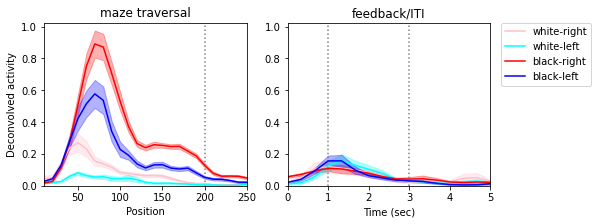

In [ ]:
# Plot trial type-average activity 
i_neuron = 1  # change this to view different neurons in the dataset
plot_trial_type_activity(data, i_neuron)

The activity clearly depends on the trial type, but there is significant variability in activity patterns on different trials of the same type, as other factors, such as running velocities, may also contribute to modulation of neural activities. One may notice that, for many neurons, the activity is also dependent on the specific maze positions or time in feedback/ITI, which we called "trial phase". This trial phase specificity is a common feature of neurons recorded from posterior cortex during various navigation of decision making task (We will make use of this in the next section when we perform feature engineering to generate design matrix for our models). Similarly, one can make plots to investigate a neuron's tuning to other variables, such as running velocity or strategy variables. However, it can be tedious to study each neuron's response properties this way, and oftentimes many variables are correlated, making intepretation of these plots tricky. To further tease apart the contribution of different variables in a more statistically principled way, we will use GLMs to explore which variables measured during individual datapoints are most useful for explaining the responses of a neuron.



## Section 2: Build design matrix for generalized linear models

We will fit a Poisson GLM to predict the neural response $y$ as:

$ log(y) = w_0 + w_1x_1 + w_2x_2 + ... = w_0 + \vec{w}X$

where $log$ is the *link function*.

Or equivalently, we can express the model as:

$ y = exp(w_0 + w_1x_1 + w_2x_2 + ...) = exp(w_0 + \vec{w}X)$

with $exp$ as the *activation function*.

Here $x_1$, $x_2$, ... are our various variables/features, $w_1$, $w_2$, ... are the the corresponding weights to be learned, which represent how these features influence neural activity, and $w_0$ is the intercept that determines baseline activity of the neuron (also learned by the fitting process). Neural response $y$ is assumed to follow Poisson distributions, which is a commonly used assumption for spike count data, and can be extended to deconvolved activities (proxy of spike counts) in calcium imaging.

See this wiki page for more information: https://en.wikipedia.org/wiki/Poisson_regression

### Section 2.1: Position basis expansion

We start with building a design matrix $X$ that contains all the variables/feautres we are interested in relating neural activity to in our GLM. 

When building the design matrix, it is a common practice to perform "feature engineering" from the raw features in specific forms that align with relevant domain knowledge. For neural activity in posterior cortex during spatial navigation, it is known (or observed) that individual neurons show position-specific tuning to different task variables, i.e. their response to task variables (such as the cue) can be present/strong in one spatial position but absent/weak in another. To express the tuning as a function of spatial position, we want to create a set of **position basis functions** (similar to "place fields") that tile the full length of the maze. We then use these to construct new features (task features * position basis functions) and incorporate them into our design matrix. This allows the model to have different parameters for the influence of each task variable at different parts of the maze. 

A common selection of the position basis function is **raised cosine bumps** with the general form:

$$f_i(x) =
  \begin{cases}
    \frac{1}{2} \cos( ax  - \varphi_i ) + \frac{1}{2}       & \quad \text{if } \varphi_i - \pi < ax \leq \varphi_i + \pi\\
    0  & \quad \text{otherwise } 
  \end{cases}
$$

where $\varphi_i$ is the center location of the $i^{th}$ bump, and $a$ is a scaling factor that controls the width of the bump.

Note that we choose **raised cosine bumps** as our basis functions instead of Gaussian bumps because with proper width-to-spacing ratio (minimal ratio required is 2:1, but we normally use higher ratio for denser basis functions), all raised cosine bumps sum up to a constant, meaning that the space is tiled completely and evenly.

We have implemented the function `eval_cosine_bump` below for building the basis functions.

In [4]:
def create_cosine_bumps(x, centers, widths):
  '''Create raised cosine bumps

  Input parameters::
  x: x positions to evaluate the cosine bumps on, ndarray of shape (n_samples, )
  centers: contains center positions of bumps, ndarray of shape (number of bumps, )
  widths: the width of each bump, should be same shape as centers

  Returns::
  bases: basis functions, ndarray of shape (n_samples, number of bumps)
  '''
  # Sanity check
  assert centers.shape == widths.shape, 'Centers and widths should have same number of elements'  
  x_reshape = x.reshape(-1,)

  # Create empty array for basis functions
  bases = np.full((x.shape[0], centers.shape[0]), np.NaN)
  
  # Loop over center positions
  for idx, cent in enumerate(centers):
    bases[:, idx] = (np.cos(2 * np.pi * (x_reshape - cent) / widths[idx]) * 0.5 + 0.5) * \
                    (np.absolute(x_reshape - cent) < widths[idx] / 2)
  
  return bases

#### Create position basis functions

Let's create 20 basis functions that tile the maze (from start position = 10 to end position = 250). 

Notice that the width-to-spacing ratio is set to 4:1, which is a commonly used empirical value that adjacent bases are spaced by $\frac{\pi}{2}$. As mentioned earlier, the minimal ratio required to tile the space is 2:1, but one can increase this number to create denser basis funcitons (with the trade-off to overly parametrize the maze positions).

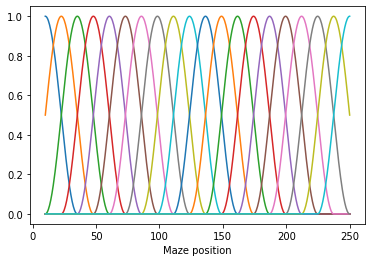

In [ ]:
## Create position basis functions
# Set parameters
start_pos = 10
end_pos = 250
n_pos_bases = 20

# Linearly space the centers of the position bases
pos_centers = np.linspace(start_pos, end_pos, n_pos_bases)

# Set width of the position bases as 4 times spacing
width_to_spacing_ratio = 4
pos_width = width_to_spacing_ratio * scipy.stats.mode(np.diff(pos_centers))[0][0]

# Evaluate the values of the position series on each base (for visualization purpose)
# Note: the number of datapoints here is arbitrary; it just has to be of enough resolution when we visualize the basis functions
positions = np.linspace(start_pos, end_pos, 500)
pos_bases = create_cosine_bumps(positions, pos_centers, pos_width * np.ones_like(pos_centers))

# Visualize
fig, ax = plt.subplots()
ax.plot(positions, pos_bases)
ax.set(xlabel = 'Maze position');

#### Evalute the real forward position at the basis functions

Here we evalute the values of real time series of the forward maze position at each position basis function. From now on, it's a good practice to establish a good **naming system** for expanded features so that we can keep track of their identities easily. Here we use `fPos_bump#` to denote each basis, with # being the number of that basis. You will see how this becomes handy later when we want to (1) group variables during fitting for specific choice of regularization, (2) extract weights of a specific group of expanded features after fitting, or (3) quantify feature importance/contribution.

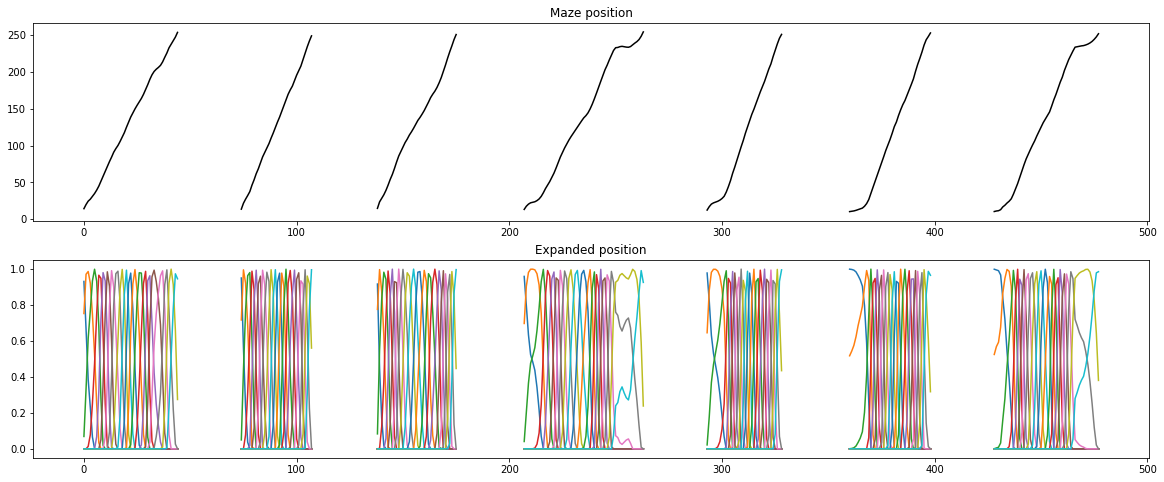

In [ ]:
## Apply position basis functions to forward maze position
# Evaluate the basis expanded forward position at each basis
posF = data['posF'].copy() # extract time series of real forward position for data
f_pos_bases = create_cosine_bumps(posF, pos_centers, pos_width * np.ones_like(pos_centers)) # position basis expansion
f_pos_names = [f'fPos_bump{i}' for i in range(len(pos_centers))] # create a list of names for each expanded feature

# Visualize for the first 500 timepoints
fig, axes = plt.subplots(2, 1, figsize = (20, 8))
axes[0].plot(posF[:500], 'k')
axes[0].set(title='Maze position')
axes[1].plot(f_pos_bases[:500,:])
axes[1].set(title='Expanded position');

In [ ]:
# Check the names and dimension of the expanded positions
print('Names =', f_pos_names,'\nShape of expanded positions =',f_pos_bases.shape)

Names = ['fPos_bump0', 'fPos_bump1', 'fPos_bump2', 'fPos_bump3', 'fPos_bump4', 'fPos_bump5', 'fPos_bump6', 'fPos_bump7', 'fPos_bump8', 'fPos_bump9', 'fPos_bump10', 'fPos_bump11', 'fPos_bump12', 'fPos_bump13', 'fPos_bump14', 'fPos_bump15', 'fPos_bump16', 'fPos_bump17', 'fPos_bump18', 'fPos_bump19'] 
Shape of expanded positions = (27396, 20)


#### Apply position basis functions to task variables

Now we can load the task variables onto these expanded position bases by taking the **product** of the time series of the expanded position and the selected variables, i.e. creating *interaction terms* of task variables and position bases. We want to apply the basis expansion for all task variables in our dataset (but not inclusing movement variables). Here we append the basis name (`fPos_bump#`) to the end of the task variables for each interaction to keep track of feature names. The expanded position features are included in the expanded features too (with `trialPhase` attached before `fPos_bump#`), which can be interpreted as task variable-invariant position tuning.

In [ ]:
## Apply forward position bases to task variables
var_names = list(data['task_var'].keys())

# Initialize features and names with expanded position bases
expanded_features_pos = np.full((f_pos_bases.shape[0], n_pos_bases * (len(var_names) + 1)), np.NaN)
expanded_features_pos[:, :f_pos_bases.shape[1]] = f_pos_bases.copy()
expanded_feature_names_pos = [f'trialPhase_{base_name}' for base_name in f_pos_names] # attach 'trialPhase' before 'fPos_bump#'

# Multiply individual variables with expanded position predictors
for i, name in enumerate(var_names):  
    expanded_features_pos[:, (i + 1) * n_pos_bases:(i + 2) * n_pos_bases] = data['task_var'][name][:, None] * f_pos_bases
    expanded_feature_names_pos += [f'{name}_{base_name}' for base_name in f_pos_names]
    
print('Shape of position expanded features =', expanded_features_pos.shape, '\nNumber of position expanded features =', len(expanded_feature_names_pos))

Shape of position expanded features = (27396, 180) 
Number of position expanded features = 180


We can visualize one of the position expanded task variables: cue. Here we make use of the naming system to identify indices that correspond to position expanded cue.

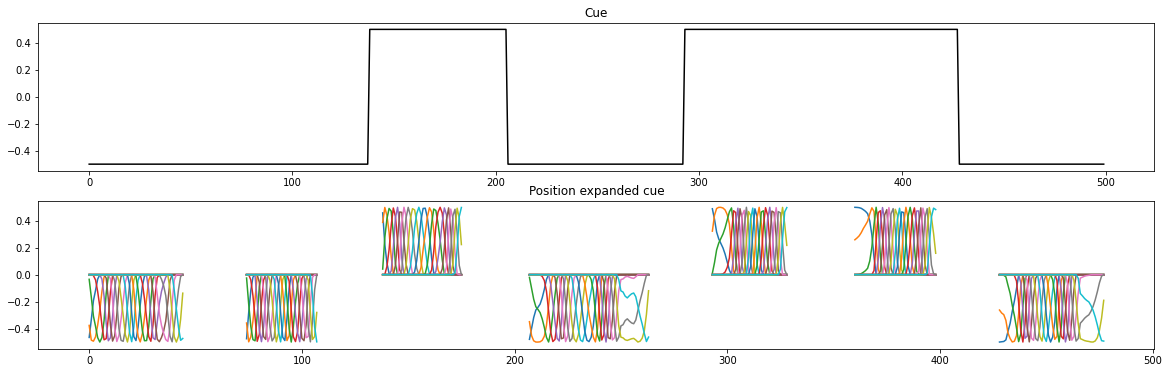

In [ ]:
## Plot expanded cue
# Use the name list to identify the range of indices
start_idx = expanded_feature_names_pos.index('cue_fPos_bump0')
end_idx = expanded_feature_names_pos.index('cue_fPos_bump{}'.format(n_pos_bases - 1))

# Visualize position expanded cue for the first 500 timepoints
fig, axes = plt.subplots(2, 1, figsize = (20, 6))
axes[0].plot(data['task_var']['cue'][:500],'k')
axes[0].set(title = 'Cue')
axes[1].plot(expanded_features_pos[:500, start_idx:end_idx+1])
axes[1].set(title = 'Position expanded cue');

### Section 2.2: Temporal basis expansion



#### Apply temporal basis expansion for task variables in feedback/ITI

Similar to position-specific tuning of task variables during maze traversal, some neurons are more active in feedback/ITI and have activity specific to different periods of time (similar idea to "time cells"). We want to apply basis expansion on time during this period, and generate temporally expanded features for each task variables.

Here we are choosing 13 temporal basis functions that tile across t = 0 to t = 5 sec in feedback/ITI.

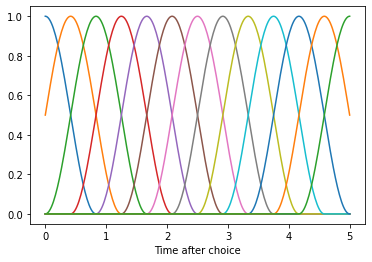

In [ ]:
## Create temporal basis functions
# Set parameters
start_time = 0
end_time = 5
n_tm_bases = 13

# Linearly space the centers of the position bases
tm_centers = np.linspace(start_time, end_time, n_tm_bases)

# Set width of the position bases as 4 times spacing
width_to_spacing_ratio = 4
tm_width = width_to_spacing_ratio * scipy.stats.mode(np.diff(tm_centers))[0][0]

# Evaluate the values of the position series on each base for visualization purpose
# Note: the number of datapoints here is arbitrary; it just has to be of enough resolution when we visualize
timepoints = np.linspace(start_time, end_time, 300)
tm_bases = create_cosine_bumps(timepoints, tm_centers, tm_width * np.ones_like(tm_centers))

# Visualize
fig, ax = plt.subplots()
ax.plot(timepoints, tm_bases)
ax.set(xlabel = 'Time after choice');

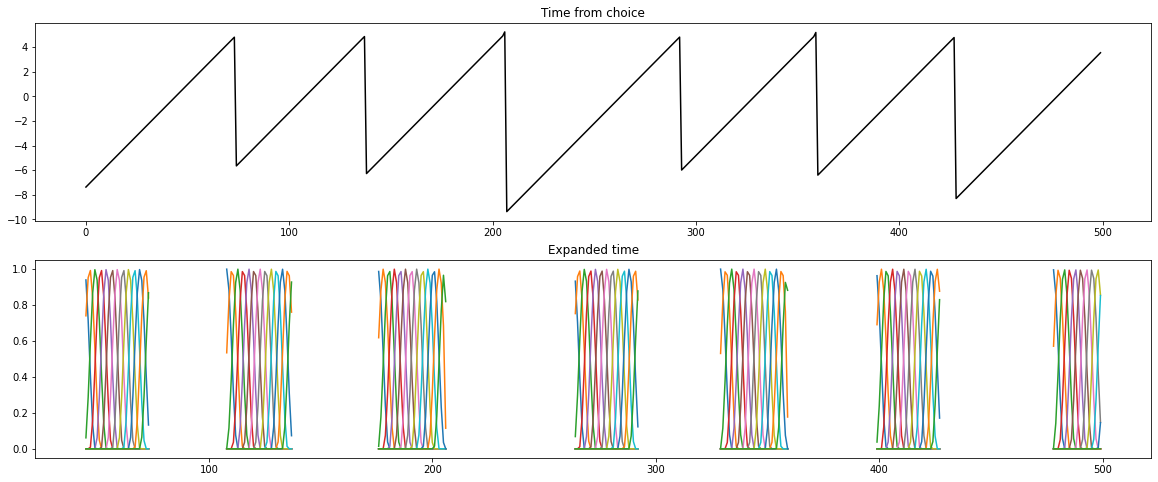

In [ ]:
## Apply temporal basis functions to actual time from choice in data
time_from_cho = data['time_from_cho'].copy() # extract time elapsed from data
time_from_cho[time_from_cho < 0] = np.NaN # exclude datapoints not in feedback/ITI

# Evaluate the basis expanded time at each basis and create list of expanded feature names
cho_tm_bases = create_cosine_bumps(time_from_cho, tm_centers, tm_width * np.ones_like(tm_centers))
cho_tm_names = [f'choTm_bump{i}' for i in range(len(tm_centers))]

# Visualize for the first 500 timepoints
fig, axes = plt.subplots(2, 1, figsize = (20, 8))
axes[0].plot(data['time_from_cho'][:500], 'k')
axes[0].set(title='Time from choice')
axes[1].plot(cho_tm_bases[:500,:])
axes[1].set(title='Expanded time');

In [ ]:
## Apply temporal bases to task variables
var_names = list(data['task_var'].keys())

# Initialize features and names with expanded timepoints
expanded_features_tm = np.full((cho_tm_bases.shape[0], n_tm_bases * (len(var_names) + 1)), np.NaN)
expanded_features_tm[:, :cho_tm_bases.shape[1]] = cho_tm_bases.copy()
expanded_feature_names_tm = [f'trialPhase_{base_name}' for base_name in cho_tm_names] # attach 'trialPhase' before 'choTm_bump#'

# Multiply individual variables with expanded position predictors
for i, name in enumerate(var_names):  
    expanded_features_tm[:, (i + 1) * n_tm_bases:(i + 2) * n_tm_bases] = data['task_var'][name][:, None] * cho_tm_bases
    expanded_feature_names_tm += [f'{name}_{base_name}' for base_name in cho_tm_names]
    
print('Shape of temporally expanded features =', expanded_features_tm.shape, '\nNumber of temporally expanded features =', len(expanded_feature_names_tm))

Shape of temporally expanded features = (27396, 117) 
Number of temporally expanded features = 117


### Section 2.3: Basis expansion for movement variables


For movement-related variables (`pitch`, `roll` and `yaw` velocities of the spherical treadmill), we assume that neurons tuned to these variables should show consistent relationship with them, i.e. a neuron should be tuned to velocities the same way when the mouse was at different maze positions as when it was in feedback/ITI. Therefore, we don't want to perform position or temporal basis expansion on movement variables. Note that this is an assumption / specific modeling choice. You may have different considerations for how velocity tuning should look like in a different scenario.

One could simply plug in the movement variables as predictors and estimate the linear relationship between neural activity and instantaneous velocities. One could also create temporal shifts of these movement variables, both forward and backward in time, to estimate neural tuning to past and future movement.

Here, we would like to only consider neural responses related to instantaneous velocities, but allow some non-linear tuning. For example, a neuron could be tuned to medium level of velocities but not high/low values. Therefore, we want to perform basis expansion on the velocity values themselves. One can again use **raised cosine bumps**, but here, we wouldd like to demonstrate another type of basis expansion: **B-splines**. 


#### B-splines expansion

Splines are a form of higher order polynomial functions used in creating non-linear features. B-splines, or basis splines, are bump-like basis functions that also tile the space and sum up to 1. 

We are using the `SplineTransformer` from sklearn to generate b-splines. One common choice is degree 3 b-spline functions, with a reasonable number of knots that tile the value space. Here we choose 5 knots, which gives us 3 + 5 - 1 = 7 basis functions in total.

Documentation for `SplineTransformer`:

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html

Here we visualize the b-splines.


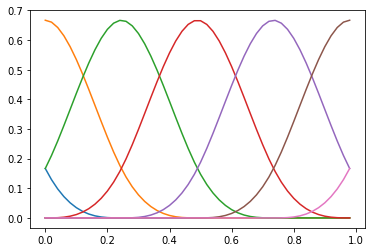

In [5]:
# Create b-splines on a support between 0 to 1 (works on quantile transformed data; see next block below)
mvt_bins = np.arange(0,1,0.02).reshape(-1,1)  # Note: the number of datapoints here is arbitrary; it just has to be of enough resolution for visualization
spline = SplineTransformer(degree = 3, n_knots = 5, knots = 'uniform') # initialized sklearn SplineTransformer
mvt_bspl = spline.fit_transform(mvt_bins) # create b-slines

# Visualize b-splines
plt.plot(mvt_bins, mvt_bspl);

Next we would like to apply b-spline tranformation to our movement variables. Instead of applying b-splines onto the raw or z-scored velocity values directly, we will apply the b-spline tranformation to the **quantile-transformed velocities**. Because the distributions of running velocities can vary between animals and sessions, quantile transformation puts the velocity values evenly between 0 to 1 such that we can compare the "tuning" to velocity quantiles across animals and sessions easily. This was why the b-splines were created on the range between 0 to 1 with uniform knot distribution. We keep the same naming convention by adding `bump#` to the expanded feature names.

We use `QuantileTransformer` from sklearn for quantile transform. See documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html

In [6]:
## Apply b-spline expansion to movement variables
mvt_var_names = list(data['movement_var'].keys())

# Initialize for expanded features and names
expanded_features_mvt = []
expanded_feature_names_mvt = [] 

# Specify b-spline setting
degree = 3
n_konts = 5
n_bsplines = degree + n_konts - 1

# Loop over variables in movement variables and create b-spline expansion and expanded feature names
for i, var in enumerate(mvt_var_names):
    # quantile transform velocity
    this_var_quant = QuantileTransformer(n_quantiles=1000).fit_transform(data['movement_var'][var].reshape(-1,1))
    # transform velocity quantiles into b-splines
    these_splines = SplineTransformer(degree=degree, n_knots=n_konts, knots='uniform').fit_transform(this_var_quant)
    # append features and feature names
    expanded_features_mvt.append(these_splines)
    expanded_feature_names_mvt.extend([f'{var}_bump{i}' for i in range(n_bsplines)])

# Concatenate expanded features for all movement variables
expanded_features_mvt = np.hstack(expanded_features_mvt)

print('Shape of expanded movement features =', expanded_features_mvt.shape, '\nNumber of expanded movement features =', len(expanded_feature_names_mvt))

Shape of expanded movement features = (27396, 21) 
Number of expanded movement features = 21


We can visualize one of the B-spline expanded velocity (pitch).

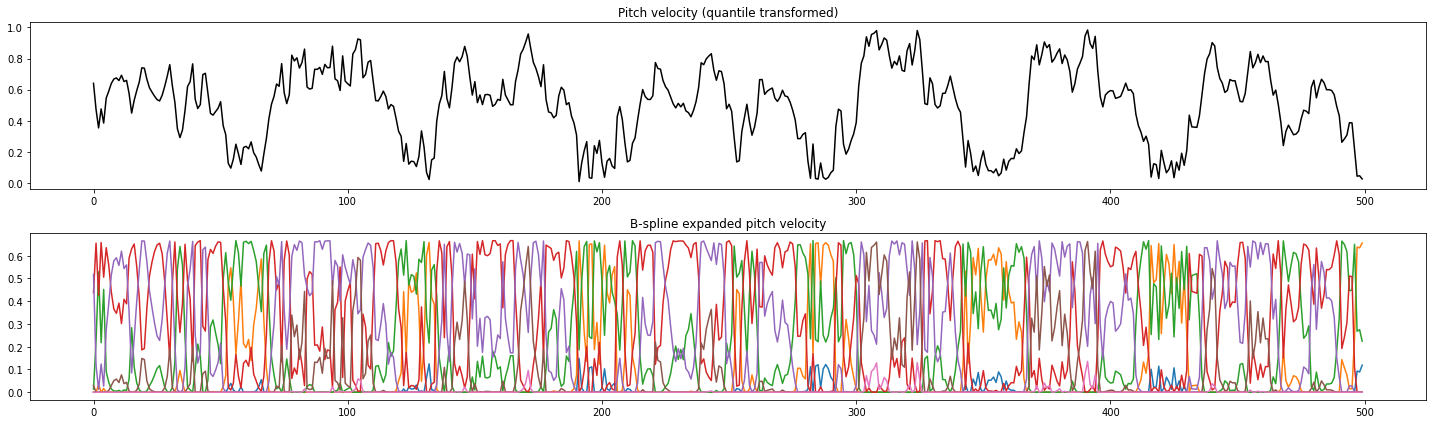

In [11]:
## Plot b-spline expanded pitch velocity
# Use the name list to identify the range of indices
start_idx = expanded_feature_names_mvt.index('pitch_bump0')
end_idx = expanded_feature_names_mvt.index('pitch_bump{}'.format(n_bsplines - 1))

# Visualize b-spline expanded pitch velocity for the first 500 timepoints
fig, axes = plt.subplots(2, 1, figsize = (20, 6))
pitch_quant = QuantileTransformer(n_quantiles=1000).fit_transform(data['movement_var']['pitch'].reshape(-1,1))
axes[0].plot(pitch_quant[:500],'k')
axes[0].set(title = 'Pitch velocity (quantile transformed)')
axes[1].plot(expanded_features_mvt[:500, start_idx:end_idx+1])
axes[1].set(title = 'B-spline expanded pitch velocity')
plt.tight_layout()

### Section 2.4: Combine and group features

#### Combine all features and feature names

Now we've processed all the features into basis expanded features; we can collect them together to construct the design matrix.

Note that one may even consider more complex features, such as interaction terms between task variables expanded by positions and/or time, or interactions between movement variables (there are 2D b-splines for pairwise interactions of movement variables; however, sklearn currently doesn't have implementation and one should look for other packages for statistical analysis), or include any other variables that come from experimental measurements or modeling.

In [ ]:
# Combine all features and feature names
all_features = np.concatenate((expanded_features_pos, expanded_features_tm, expanded_features_mvt), axis=1)
all_feature_names = expanded_feature_names_pos.copy()
all_feature_names.extend(expanded_feature_names_tm)
all_feature_names.extend(expanded_feature_names_mvt)

print('Shape of all features combined =', all_features.shape, '\nNumber of all expanded features =', len(all_feature_names))

Shape of all features combined = (27396, 318) 
Number of all expanded features = 318


#### Feature grouping

We note that all our features are in groups: from position basis expansion, temporal basis expansion, or b-spline expansion. It is useful to have a handle on the grouping information before we start fitting our models, as the grouping information will be used in multiple places later:

- Regularization in fitting
- Extract weights for all features in the same group
- Quantify feature contribution

The function below `parse_group_from_feature_names` goes through the list of the feature names and partition them into groups, and here is where the naming systems come into play. This function goes over all feature names, identifies a feature with `bump0` as the start of a group and assigns all following features with `bump#` into the same group until it hits the next feature with `bump0`. If there's no `bump` in the feature name, that feature gets assigned to its own group. It returns three items:
- `group_size`: a list of number of features in each group
- `group_name`: the name of each group, same length of `group_size`
- `group_ind`: the group index for each feature in feature names


In practice, one should write their own parsing function tailored to their own particular naming systems and rules.

In [ ]:
def parse_group_from_feature_names(feature_names):
    ''' 
    Parse feature_names into groups using hand-crafted rules

    Input parameters:: 
    feature_names: List of feature names. In this example, expanded features must contain bumpX in the name

    Returns:: 
    group_size: list of number of features in each group
    group_name: name of each group
    group_ind: group index of each feature in feature_names, ndarray of size (len(feature_names),)
    '''
    
    # Find expanded features and their number of sub-features:
    group_size = list()
    group_name = list()
    group_ind = list()
    for name in feature_names:
        if 'bump' not in name:
            # Non-bump expanded feature:
            group_size.append(1)
            group_name.append(name)

        elif 'bump0' in name:
            # First bump of a bump-expanded feature:
            group_size.append(1)
            group_name.append(name[:-6])

        else: 
            # Subsequent time shifts and bumps
            group_size[-1] += 1  

    # Create group index for each feature
    for i_group, this_size in enumerate(group_size):
        group_ind += [i_group]*this_size
    
    return group_size, group_name, np.array(group_ind)

Let's create grouping and examine them:

In [ ]:
# Parse feature group
group_size, group_name, group_ind = parse_group_from_feature_names(all_feature_names)
print('Number of groups =', len(group_size))

Number of groups = 21


In [ ]:
# Examine size of each group
print(group_size)

[20, 20, 20, 20, 20, 20, 20, 20, 20, 13, 13, 13, 13, 13, 13, 13, 13, 13, 7, 7, 7]


Groups with size 20: position expanded groups

Groups with size 13: temproally expanded groups

Groups with size 7: b-spline expanded groups

In [ ]:
# Examine group name
print(group_name)

['trialPhase_fPos', 'cue_fPos', 'cho_fPos', 'corr_fPos', 'prevCorr_fPos', 'rule_following_fPos', 'bias_following_fPos', 'belief_fPos', 'dyn_cho_fPos', 'trialPhase_choTm', 'cue_choTm', 'cho_choTm', 'corr_choTm', 'prevCorr_choTm', 'rule_following_choTm', 'bias_following_choTm', 'belief_choTm', 'dyn_cho_choTm', 'pitch', 'roll', 'yaw']


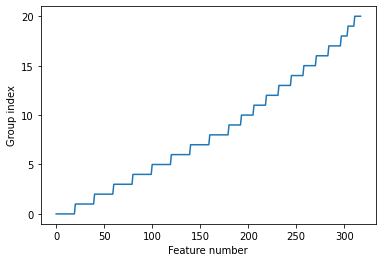

In [ ]:
# Examine group index for each feature
plt.plot(group_ind)
plt.yticks(np.arange(0,len(group_size),5))
plt.xlabel('Feature number')
plt.ylabel('Group index');

Note that features are assigned into blocks of groups.

#### Model summary

Below is the schematic of our model:

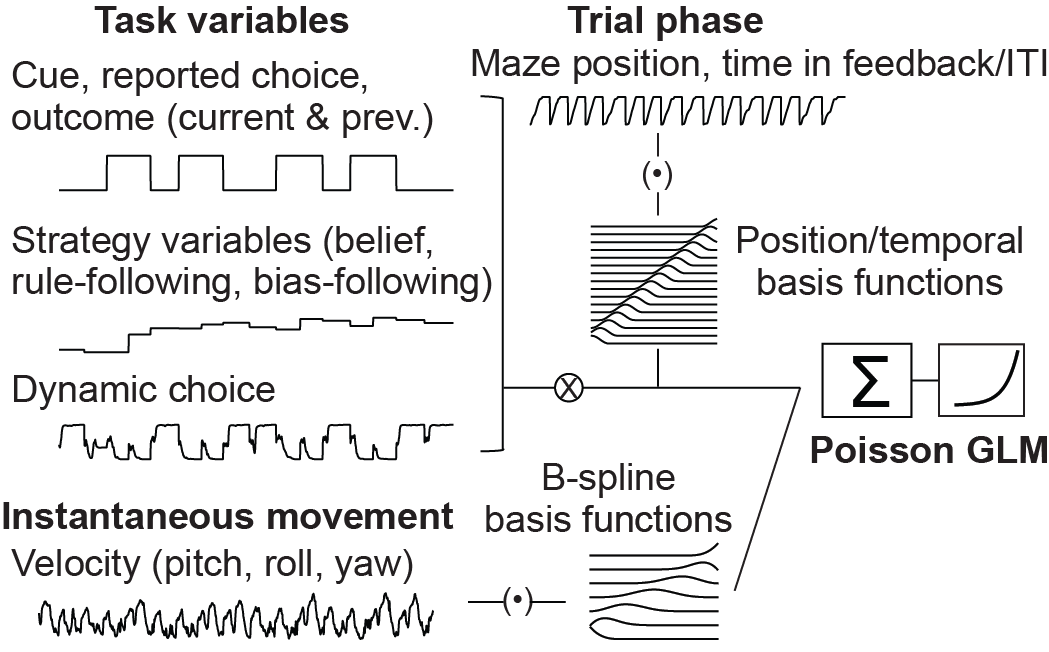

## Section 3: Model fitting, selection, and evaluation

### Section 3.1: Data pre-processing and train-test split

First we clean up the features and z-score along the sample dimension to generate final design matrix X. Note that z-scoring helps regularization to exert even effect across different features. We also multiply the dencovolved activity by 10 to generate the response matrix Y. The reason is that, empirically, deconvolved activity of 0.1 roughly corresponds to 1 spike, and we want to mimic the spike count when fitting a Poisson GLM. 

In [ ]:
# Clean up design matrix and z-score along sample dimension
all_features[np.isnan(all_features)] = 0
X = scipy.stats.zscore(all_features, axis = 0)

# Multiply deconvolved activity by 10 to mimic spike number
Y = 10. * data['deconv']

Next we perform train-test split to the data. The training data will go into fitting the models with cross validation, whereas the test data is set aside for model evaluation later. 

Here we want to split the datapoints based on the `trial_id`, i.e. all timepoints within a trial should be split into the same set. We can use `GroupShuffleSplit` function from sklearn to achieve this, which splits data according to a third-party provided groups.

See documentation for `GroupShuffleSplit`: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html

In [ ]:
# Get indices for splitting according to trial_id 
n_samples = X.shape[0]
group_id = data['trial_num']
gss = GroupShuffleSplit(n_splits = 1, train_size = 0.85, random_state = 42)
train_idx, test_idx = next(gss.split(X, Y, group_id))

# Split data into train and test set
X_train = X[train_idx,:]
Y_train = Y[train_idx,:]
X_test = X[test_idx,:]
Y_test = Y[test_idx,:]
trial_id_train = group_id[train_idx] # extract trial_id for training data, which is used in CV splits later during fitting

### Section 3.2: Model initialization and fitting

Before initiating a model, it's best practice to clear any previous "states" of tensorflow keras from previous session by doing: 
```
tf.keras.backend.clear_session()
```

Here we initialize a GLM_CV model with 5-fold cross validation. We let the model to perform CV split automatically based on the trial_id of training data (which we provide later) as group information. We choose `exp` as activation function and `poisson` as loss type for Poisson GLMs. We also choose `group_lasso` as regularization method so it will perform L1 regularization between feature groups (for sparsity) and L2 regularization within feature groups (for richness). 

The range and values of `lambda_series` and `learning_rate` are chosen based on prior survey of the fitting process on similar dataset. In practice, one can start with fitting GLM without cross validation across a range of hyperparameters, examine the loss curve and model performance, and decide on the best set of hyperparameters.

In [ ]:
# Reset keras states
tf.keras.backend.clear_session()

# Initialize GLM_CV (here we're only specifying key input arguments; others are left as default values; see documentation for details)
model_cv = glm.GLM_CV(n_folds = 5, auto_split = True, split_by_group = True,
                      activation = 'exp', loss_type = 'poisson', 
                      regularization = 'group_lasso', lambda_series = 10.0 ** np.linspace(-1, -6, 11), 
                      optimizer = 'adam', learning_rate = 1e-2)


We call the `fit` method to train the model. During training, we need to provide `trial_id_train` as `group_idx` for CV split, and `group_size` as `feature_group_size` for regularization. *(Do not get confused with the two types of "groups" here. `group_idx` is used for CV spliting, and `feature_group_size` is for regualrization when you choose `group_lasso`.)*

In [ ]:
# Fit the GLM_CV on training data
model_cv.fit(X_train, Y_train, group_idx = trial_id_train, feature_group_size = group_size, verbose = True) 

n_fold = 0
Lambda 0 iter 100 loss: 0.65418148 diff: 0.00349781
Lambda 0 iter 200 loss: 0.60579377 diff: 0.00048115
Lambda 0 iter 300 loss: 0.59301734 diff: 0.00012659
Lambda 0 iter 400 loss: 0.58897400 diff: 0.00003944
Lambda 0 iter 500 loss: 0.58721960 diff: 0.00001592
Lambda 0 iter 600 loss: 0.58640993 diff: 0.00001024
Fitting with Lambda 0 iter 700 converged (loss diff = -0.00000011)
Lambda 1 iter 100 loss: 0.47606534 diff: 0.00042038
Lambda 1 iter 200 loss: 0.47568578 diff: 0.00000380
Fitting with Lambda 1 iter 300 converged (loss diff = 0.00000032)
Lambda 2 iter 100 loss: 0.39689842 diff: 0.00023286
Lambda 2 iter 200 loss: 0.39632449 diff: 0.00000567
Fitting with Lambda 2 iter 300 converged (loss diff = 0.00000153)
Lambda 3 iter 100 loss: 0.34910417 diff: 0.00010204
Lambda 3 iter 200 loss: 0.34852603 diff: 0.00000573
Lambda 3 iter 300 loss: 0.34832883 diff: 0.00000196
Fitting with Lambda 3 iter 400 converged (loss diff = 0.00000084)
Lambda 4 iter 100 loss: 0.32424346 diff: 0.00003

#### Section 3.3: Model selection, evaluation, and prediction

Here we select models with best regularization strength for each neuron by calling the `select_model` method. Note that we choose `se_fraction = 0.` here, instead of `se_fraction = 1.` (commonly used One-standard-error rule), because we already know from prior experience that `se_fraction = 0.` works better even on our test data. One should carefully evaluate their own data and make a decision.



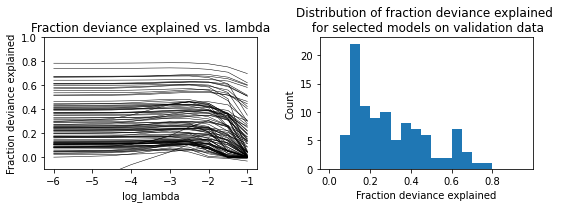

In [ ]:
# Select models based on CV performance
model_cv.select_model(se_fraction = 0., min_lambda = 0., make_fig = True)

To evaluate the performance of the Poisson GLM, we use **fraction deviance explained**, analogous the fraction variance explained, or $R^2$ for ordinary (Gaussian) linear model.

$\text{fraction deviance explained} = 1 - \frac{\text{model deviance}}{\text{null deviance}}$

The deviance compares the log-likelihood of a (virtual) model that captures all variability in the data to log-likelihood of the actual model fits. The fraction deviance explained compares the model deviance to that of a null model that assumes the same (average) prediction for each time point. For more information see: https://en.wikipedia.org/wiki/Deviance_(statistics).

Here we call the `evaluate` method on test data, which returns the fraction deviance explained, model deviance, null deviance and explained deviance for each neurons using weights from the selected regularization strengths.

Fraction deviance explained: mean = 0.3012, median = 0.2557


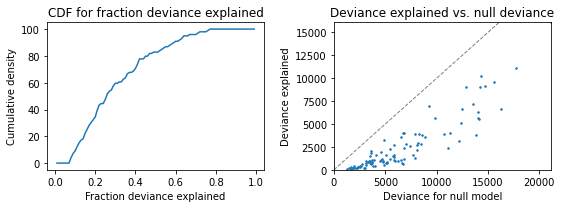

In [ ]:
# Evaluate model performance on test data
frac_dev_expl, dev_model, dev_null, dev_expl = model_cv.evaluate(X_test, Y_test, make_fig = True)

We can then make prediction on the test data by calling the `predict` method, and compare that with real data.


In [ ]:
# Make prediction on test data
y_pred = model_cv.predict(X_test)
print(y_pred.shape)

(4133, 100)


Fraction deviance explained = 0.39


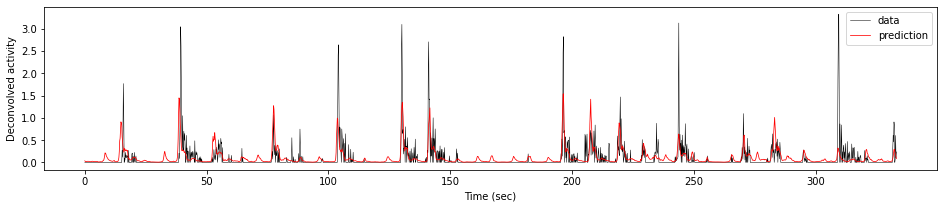

In [ ]:
# Compare data and prediction for selected neuron
i_neuron = 1 # change this to examine different neurons
n_timepoints = 2000
fig,ax = plt.subplots(figsize = (16,3))
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, Y_test[:n_timepoints, i_neuron]/10, 'k', lw = 0.5, label = 'data')
plt.plot(np.arange(n_timepoints)/sampling_freq_hz, y_pred[:n_timepoints, i_neuron]/10, 'r', lw = 0.75, label = 'prediction')
plt.xlabel('Time (sec)')
plt.ylabel('Deconvolved activity')
plt.legend()
print(f'Fraction deviance explained = {frac_dev_expl[i_neuron]:.2f}')

From the block above, you can change `n_neuron` to see how the prediction looks like for neurons with different fit quality (fraction deviance explained). Note that the models predict the "firing rate" at each timepoint, where the data is assumed to be the "observed firing count" generated with Poisson noise.

*Note that the `evaluate` and `predict` methods can be called on training data too, if you would like to see how the models perform and make predictions on training data.*

## Section 4: Quantify feature importance/contribution

Besides evaluating the model performance based on fraction deviance explained, we often want to know the importance or contribution of different variables in explaining a neuron's activity, and then compare across different neurons. There are several ways to assess a variable's contribution. One way is to look at the **model weights (coefficients)** directly. Alternately, we can evaluate the **"fraction null deviance"** or **"fraction explained deviance"** of each variable using different procedures. There are pros and cons of different ways and they are complementary to each other. In this section, we will see how to perform these different ways to quantify feature importance/contribution.

### Section 4.1: Model weights (coefficients)

The model weights (coefficients) provide an easy access to the magnitude and directionality (because they are signed) of how a variable modulates the response. In the context of neural activity, the model weights describe the "tuning" of the neuron to the variables of interests. Here we will demonstrate how to extract and visualize fitted model weights; specifically, we will compute the "tuning function" (or "kernel") of a feature group, by multiplying the fitted weight of each expanded feature with the basis functions and summing them up. Note that these are the linear kernels before the activation function is applied. Recall that in the Poisson GLM models:

$ y = exp(Xw + w_0)$

The weights work as a multiplicative factors (gains) after passing through the activation function, i.e. they amplify or suppress the response $y$ on top of a baseline value (baseline firing rate of a neuron). To get the gains, you need to exponentiate these kernels.




#### Position expanded kernels

Let's start with the position kernel itself, or the position tuning function, of the first neuron. Here we make use of the naming systems to identify all expanded features with the group name `trialPhase_fPos`. Next we grab all corresponding weights from `selected_w` of the fitted model, which is an array of shape (n_features, n_neurons). We then multiply the position bases (`pos_bases`) with the weights and sum them up to obtain the position kernel.

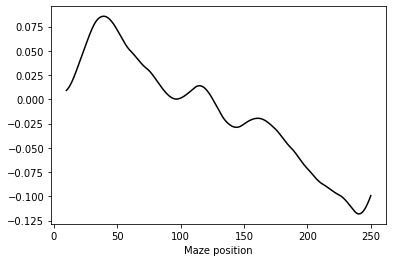

In [ ]:
# Plot position kernel for the first neuron
i_neuron = 0

# Identify indices for position bases
this_group_name = 'trialPhase_fPos'
these_ind = group_ind == group_name.index(this_group_name)

# Grab corresponding weights
weights = model_cv.selected_w[these_ind, i_neuron]

# Reconstruct tuning function
tuning = np.sum((pos_bases * weights), axis=1)

# Visualize the position kernel as a function of maze position
fig, ax = plt.subplots()
ax.plot(positions, tuning, 'k')
ax.set(xlabel = 'Maze position');

For neuron 0, its activity was modulated positively when the mouse was in early part of the maze (position < 100) and suppressed when it entered later part of the maze. 

Next we can compute the position kernels for all neurons at the same time, and visualize some of them.

(500, 100)


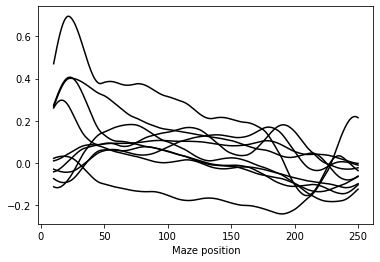

In [ ]:
# Compute position kernels for all neurons
weights = model_cv.selected_w[these_ind,:]
all_tuning = np.sum(np.expand_dims(pos_bases, axis = 2)*weights,axis=1)
print(all_tuning.shape)

# Plot position kernels for the first 10 neurons
n_selected_neurons = 10
fig, ax = plt.subplots()
ax.plot(positions, all_tuning[:,:n_selected_neurons], 'k')
ax.set(xlabel = 'Maze position');

We then loop over all position expanded task variables to obtained kernels for all the position expanded task variables for all neurons.

In [ ]:
# Get group names for all position expanded features
group_name_pos = [
    'trialPhase_fPos',
    'cue_fPos',
    'cho_fPos',
    'corr_fPos',
    'prevCorr_fPos',
    'rule_following_fPos',
    'bias_following_fPos',
    'belief_fPos',
    'dyn_cho_fPos'
]

# Extract all model weights
all_weights = model_cv.selected_w

# Loop over all groups of position expanded features to compute kernels
all_tuning_pos = [np.sum(np.expand_dims(pos_bases, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                  for this_group_name in group_name_pos]
all_tuning_pos = np.stack(all_tuning_pos, axis = 2)
print(all_tuning_pos.shape)

(500, 100, 9)


`all_tuning_pos` contains all kernels for position expanded features for all neurons, arranged as (n_positions, n_neurons, n_task_variables). Note that n_positions was defined earlier when we created and visualized the position basis functions `pos_bases`, and you can arbitrarily change the number of points (between position 10 and 250)  with ideal resolution you want.

#### Temporally expanded kernels

We can repeat the same steps for position expanded kernels on temporally expanded feature groups to obtain the temporally expanded kernels of all feature groups for all neurons.

In [ ]:
# Get group names for all temporally expanded features
group_name_tm = [
    'trialPhase_choTm',
    'cue_choTm',
    'cho_choTm',
    'corr_choTm',
    'prevCorr_choTm',
    'rule_following_choTm',
    'bias_following_choTm',
    'belief_choTm',
    'dyn_cho_choTm'
]

# Loop over all groups of temporally expanded features to compute kernels
all_tuning_tm = [np.sum(np.expand_dims(tm_bases, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                for this_group_name in group_name_tm]
all_tuning_tm = np.stack(all_tuning_tm, axis = 2)
print(all_tuning_tm.shape)

(300, 100, 9)


Same as `all_tuning_pos`, here `all_tuning_tm` contains all kernels for temporally expanded features for all neurons, arranged as (n_timepoints, n_neurons, n_task_variables). Note that n_timepoints was defined earlier when we created and visualized the temporal basis functions `tm_bases`, and you can arbitrarily change the number of points (between 0 and 5 sec)  with ideal resolution you want.

#### Movement kernels

For movement variables `pitch`, `roll` and `yaw`, we expanded them with b-splines instead of position or temporal bases. To obtain the movement kernels (or movement tuning functions) of a given movement variable, we extract the model weight corresponding to each b-spline, multiply it by the b-spline function itself (`mvt_bspl`), and sum over all b-splines. 

In [ ]:
# Get group names for all movement variables
group_name_mvt = ['pitch','roll','yaw']

# Loop over all groups of b-spline expanded movement variables to compute kernels
all_tuning_mvt = [np.sum(np.expand_dims(mvt_bspl, axis = 2) * all_weights[group_ind == group_name.index(this_group_name),:], axis=1) 
                 for this_group_name in group_name_mvt]
all_tuning_mvt = np.stack(all_tuning_mvt, axis = 2)
print(all_tuning_mvt.shape)

(50, 100, 3)


`all_tuning_mvt` contains all the movement kernels for of movement variables for all neurons, arranged as (n_quantile_bins, n_neurons, n_movement_variables). n_quantile_bins was defined earlier when we created and visualized the b-splines for movement quantiles `mvt_bspl`, and you can arbitrarily change the number of points (between 0 and 1) with ideal resolution you want.

#### Visualization of kernels

Let's visualize the kernels for position expanded task variables for some neurons.

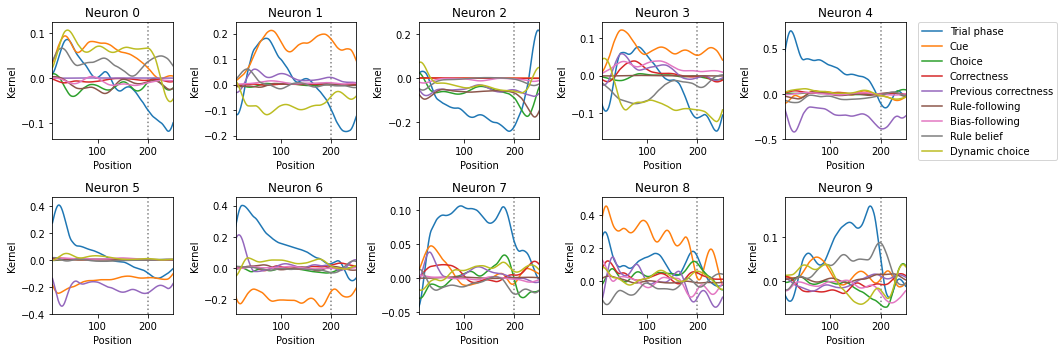

In [ ]:
# Visualize kernels for position expanded task variables for first 10 neurons (one neuron per plot)
n_selected_neurons = 10

group_name_pretty = [
    'Trial phase',
    'Cue',
    'Choice',
    'Correctness',
    'Previous correctness',
    'Rule-following',
    'Bias-following',
    'Rule belief',
    'Dynamic choice',
    'Pitch velocity',
    'Roll velocity',
    'Yaw velocity']

fig, ax = plt.subplots(2,5,figsize=(15,5))
for i_neuron in range(n_selected_neurons):
    this_ax = ax[i_neuron//5,i_neuron%5]
    this_ax.plot(positions, all_tuning_pos[:,i_neuron,:])
    this_ax.set(xlabel='Position',ylabel='Kernel',title=f'Neuron {i_neuron}')
    if i_neuron == 4:
        this_ax.legend(group_name_pretty[:-3], bbox_to_anchor=(1.1, 1),
                       loc='upper left', borderaxespad=0.)
    ymin, ymax = this_ax.get_ylim()
    this_ax.vlines(200, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    this_ax.set(ylim=[1.05*ymin, 1.05*ymax],xlim=[10,250])

plt.tight_layout()

We can see that many neurons have position preference (kernels for trial phase) at different parts of the maze. There are also many neurons with cue preference: activity of neurons 0, 1, 3, 8 were positively modulated by black cue and suppressed by white cue (with positive cue kernels), and the opposite for neurons 5 and 6. The activity of neuron 0 was positively modulated when dynamic chocie was towards left and suppresed when it was towards right, and neurons 1 and 3 showed opposite dynamic choice preference. Many neurons have tuning to multiple task variables with different position-specificity, as a common feature for cortical neurons during navigation-based decision-making tasks.

Alternately, we can plot all the tuning functions of different neurons in the same plots to compare the diversity of tuning of a particular variable across neurons.

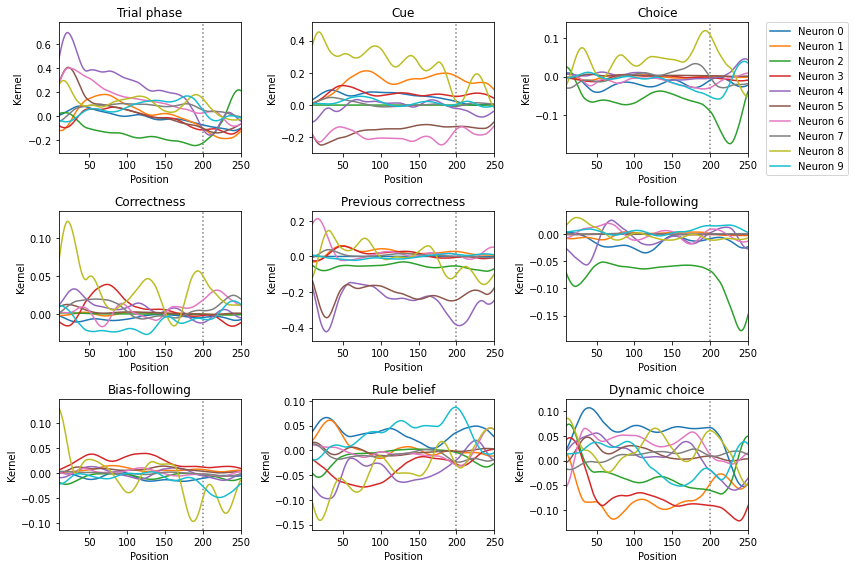

In [ ]:
# Visualize kernels for position expanded task variables for first 10 neurons (one variable per plot)
n_selected_neurons = 10
fig, ax = plt.subplots(3,3,figsize=(12,8))
for i_group, this_group_name in enumerate(group_name_pos):
    this_ax = ax[i_group//3,i_group%3]
    this_ax.plot(positions, all_tuning_pos[:,:n_selected_neurons,i_group])
    this_ax.set(xlabel='Position',ylabel='Kernel',title=group_name_pretty[i_group])
    ymin, ymax = this_ax.get_ylim()
    this_ax.vlines(200, 1.05*ymin, 1.05*ymax, color='gray',ls=':')
    this_ax.set(ylim=[1.05*ymin, 1.05*ymax],xlim=[10,250])

    if i_group == 2:
        this_ax.legend([f'Neuron {i}' for i in range(n_selected_neurons)], bbox_to_anchor=(1.1, 1),
                       loc='upper left', borderaxespad=0.)

plt.tight_layout()

We can see that there are neurons tuned to different positions in the maze, with more tuned to the beginning of the maze. We also observe neurons tuned to both black and white cues, and those tuned to both left and right dynamic choice.

To evaluate the overall strength of tuning irrespective of the directionality (sign) of tuning, we can take the absolute value of the kernels. Here we further take an average of the absolute value of kernels across all 100 neurons to show a overall tuning profile of this neural population.

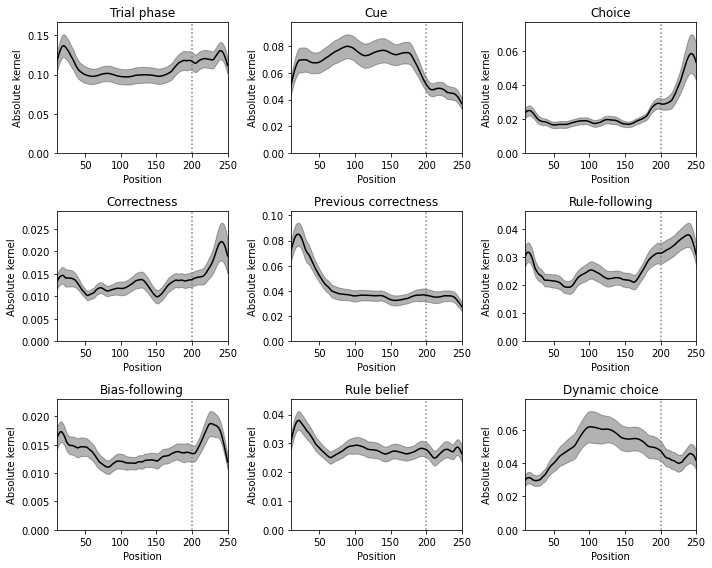

In [ ]:
# Plot mean absolute kernel values during maze traversal
n_neurons = Y.shape[1]
fig, ax = plt.subplots(3,3,figsize=(10,8))
for i_group, this_group_name in enumerate(group_name_pos):
    this_mean = np.abs(all_tuning_pos[:,:,i_group]).mean(axis=-1)
    this_sem = np.abs(all_tuning_pos[:,:,i_group]).std(axis=-1)/np.sqrt(n_neurons)
    this_ax = ax[i_group//3,i_group%3]
    this_ax.plot(positions, this_mean,'k')
    this_ax.fill_between(positions, this_mean - this_sem, this_mean + this_sem, color='k',alpha=0.3)
    this_ax.vlines(200, 0, 1.1*(this_mean + this_sem).max(), color='gray',ls=':')
    this_ax.set(xlabel='Position',ylabel='Absolute kernel',title=group_name_pretty[i_group],
                ylim=[0, 1.1*(this_mean + this_sem).max()],xlim=[10,250])

plt.tight_layout()

Pay attention to the shape of the curves w.r.t. maze position, as well as their magnitude for interpretation. For example, average tuning to maze position remained high across whole maze with peak tuning at early part of the maze (and also elevated tuning in maze arms at position 200-250). Cue tuning was higher during position 10-190 (cue onset and offset), but stayed non-zero in cue delay (190-200) and maze arms where cue was absent. Tuning to reported choice ramped up right before the mouse entered the maze arms, which cannot be dissociated from optic flow change in maze arm, whereas dynamic choice tuning was high in middle part of the maze where the visual scene was locked laterally but the animal has exhibited choice-related movement. As the animal got close to the end of the maze stem before entering the arms, the values of dynamic choice and reported choice were ususally consistent with each other, so the weight can be shared between the two variables during this part of the maze. 

The tuning to correctness remained low in maze stem but ramped up a bit in maze arms, possibly reflecting signals related to reward expectation, whereas tuning to previous correctness was higher at the start of the maze and then decayed over the trial. Rule-following somewhat measures the confidence of mouse, so the shape may look similar to that of correctness. Rule belief showed relatively flat tuning with a bit higher bumps at the trial onset. Bias-following showed very small magnitude and did not modulate neural activities a lot.

We can visualize the average absolute kernels of temporally expanded task variables in feedback/ITI too. Again pay attention to the magnitude and shape of the curve for each variable, and compare that with those position expanded variables during maze traversal.

There are neurons responding to the periods of time in feedback/ITI, shown as a relatively flat and high value for trial phase. The tuning of cue and reported choice seem to be the extension of the decay from the end of the maze, with the choice tuning being higher. Correctness, on the other hand, ramped up as the animal received the visual feedback at t = 1 sec and peaked right after they received the actual reward at t = 3 sec. All other variables showed some tuning in feedback/ITI on average, except for bias following with very small values.

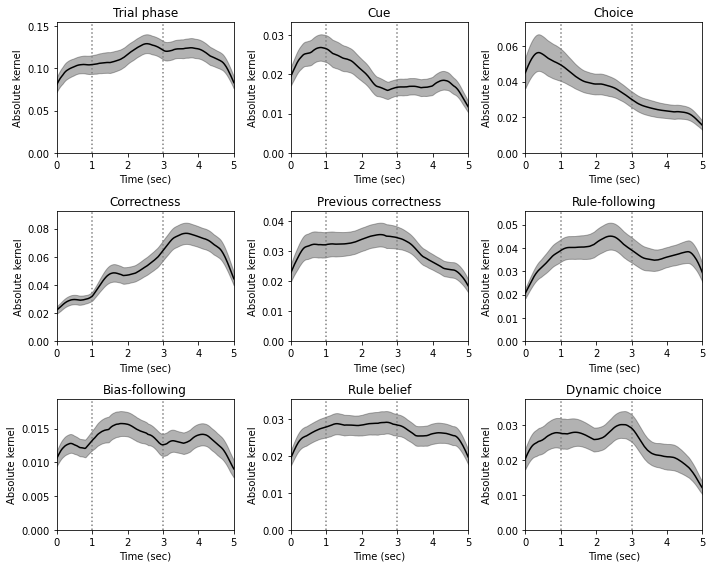

In [ ]:
# Plot mean absolute kernel values in feedback/ITI
fig, ax = plt.subplots(3,3,figsize=(10,8))
for i_group, this_group_name in enumerate(group_name_tm):
    this_mean = np.abs(all_tuning_tm[:,:,i_group]).mean(axis=-1)
    this_sem = np.abs(all_tuning_tm[:,:,i_group]).std(axis=-1)/np.sqrt(n_neurons)
    this_ax = ax[i_group//3,i_group%3]
    this_ax.plot(timepoints, this_mean,'k')
    this_ax.fill_between(timepoints, this_mean - this_sem, this_mean + this_sem, color='k',alpha=0.3)
    this_ax.vlines([1,3], 0, 1.1*(this_mean + this_sem).max(), color='gray',ls=':')
    this_ax.set(xlabel='Time (sec)',ylabel='Absolute kernel',title=group_name_pretty[i_group],
                ylim=[0, 1.1*(this_mean + this_sem).max()],xlim=[0,5])

plt.tight_layout()

For movement variables, we can plot the movement tuning curves for different neurons (first row below). We can see neurons preferring different velocity ranges of `pitch`, `roll`, and `yaw`. In the second row, we can see the average absolute movement kernels for all 100 neurons. 

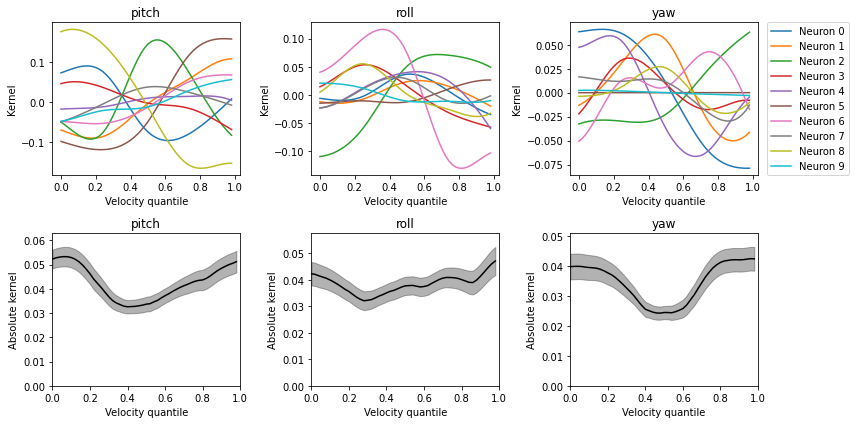

In [ ]:
# Plot velocity kernels for example neurons (first row) and mean absolute velocity kernels for all neurons (second row)
n_selected_neurons = 10
fig, ax = plt.subplots(2,3,figsize=(12,6))
for i_group, this_group_name in enumerate(group_name_mvt):
    this_ax = ax[0,i_group]
    this_ax.plot(mvt_bins, all_tuning_mvt[:,:n_selected_neurons,i_group])
    this_ax.set(xlabel='Velocity quantile',ylabel='Kernel',title=this_group_name)

    if i_group == 2:
        this_ax.legend([f'Neuron {i}' for i in range(n_selected_neurons)],bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
        
    this_ax2 = ax[1,i_group]
    this_mean = np.abs(all_tuning_mvt[:,:,i_group]).mean(axis=-1)
    this_sem = np.abs(all_tuning_mvt[:,:,i_group]).std(axis=-1)/np.sqrt(n_neurons)
    this_ax2.plot(mvt_bins.flatten(), this_mean,'k')
    this_ax2.fill_between(mvt_bins.flatten(), this_mean - this_sem, this_mean + this_sem, color='k',alpha=0.3)
    this_ax2.set(xlabel='Velocity quantile',ylabel='Absolute kernel',title=this_group_name,
                 ylim=[0, 1.1*(this_mean + this_sem).max()],xlim=[0,1])

plt.tight_layout()

Because model weights in the Poisson GLMs, after passing through the activation function, represent the multiplicative factors modulating on top of a baseline value of response $y$ (i.e. baseline firing of a neuron), their values should be robust to the baseline value of $y$. One can try to scale the activity of the neurons differently and re-fit the model; you should still get very similar weights after the scaling.

However, it is often difficult to interpret the magnitude of model weights and compare across different variables. How does a cue kernel with magnitude 0.05 compare to a roll velocity kernal with the same magnitude? Is this neuron more tuned to cue or roll velocity? 

To address this, we can instead compute the **"fraction null deviance"** or **"fraction explained deviance"** of each variable, which make the comparison easier between variables. If cue accounts for 0.05 of the null deviance of a neuron whereas the roll velocity accounts for 0.1, then we can say the roll velocity tuning is stronger for this neuron. In the following sections, we will see how to compute these metrics using two complementary methods. 

### Section 4.2: Model breakdown procedure for feature contribution

The first method we can compute feature contribution with **fraction null deviance** or **fraction explained deviance** for each variable is to perform what we call **"model breakdown"** procedure, which does not require re-fitting a new model. In gist, we evaluate the model deviance of the original model (**"full model"**) and that of an **"ablated model"** in which we remove the variable we want to evaluate on. We then compute the difference between the model deviance, and normalized it by the null deviance to compute the "fraction null deviance", or by the explained deviance of the full model to compute the "fraction expplained deviance". 
*(Don't confuse this term with "fraction deviance explained" when we report model performance; "fraction deviance explained" means how much null deviance is explained by the full model, whereas "fraction explained deviance" means how much of the explained deviance of the full model is contributed by a the variable we remove in the ablated model.)* 

Here is the schematic of the model breakdown procedure: 

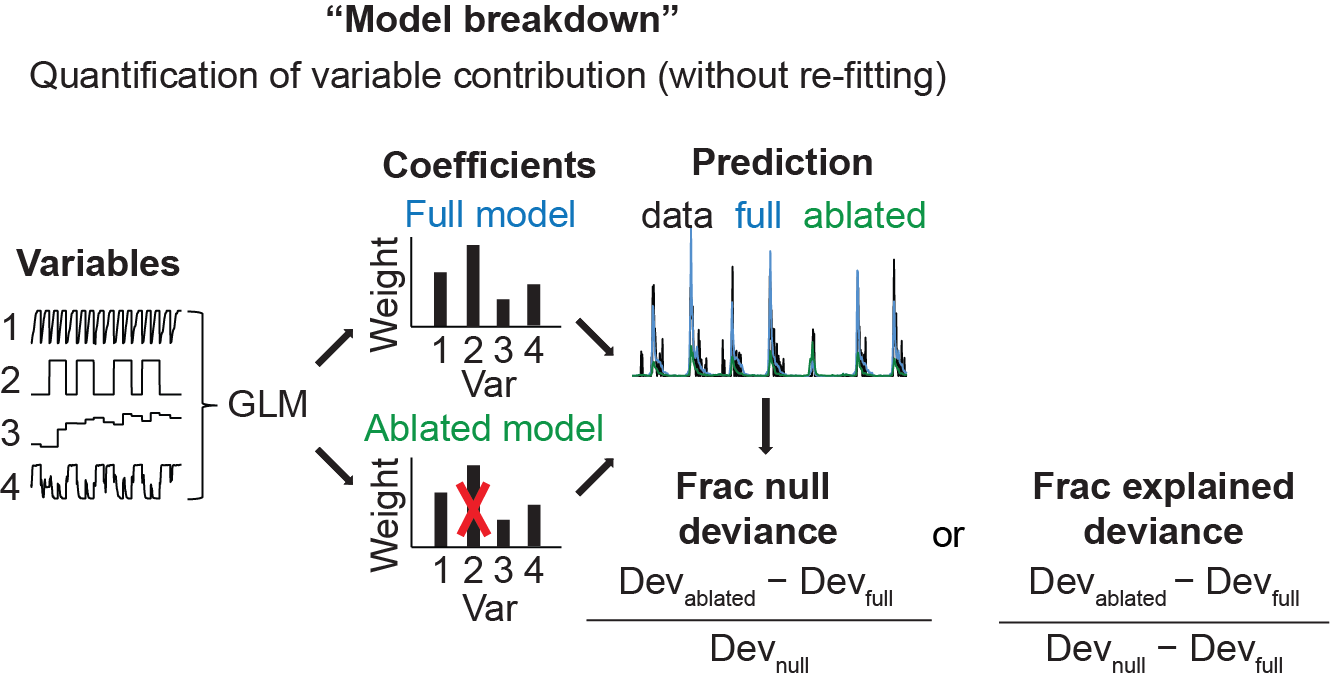

In the shcematic, we perform the ablation by zeroing the weights (coefficients) of the variable (or a group of variables). It is equivalent to zeroing the variable itself in the design matrix X. Note that the values of the variable have to be zero-centered prior to fitting and model breakdown procedure, which we normally do through zero-centering and z-scoring of the predictors, otherwise there will be an offset coming from the non-zero mean. Alternately, one can shuffle the values of the variable along sample dimension to ablate it.

We can ablate all the expanded features in one or more feature groups of a variable (e.g. all position and temporally expanded features for cue) and evaluate the difference in model deviance for all datapoints. We then bin the model deviance into position and time bins across the trial to evaluate the fraction null deviance or fraction explained deviance as a function of position during maze traversal and time in feedback/ITI. 

Here we define the position and time bins. We can re-use the function `pos_tm_binning` that we used in the first section to create trial type-averaged activity plot for binning later.


In [ ]:
## Create position and time bins for binning

# Determine position and time bin size
# We will re-use the pos_centers and tm_centers for our position and temporal basis functions as bin centers,
# and use spacing between pos_centers or tm_centers as the pos_half_width and tm_half_width,
# so the binning will be half-overlapped between adjacent bins
pos_half_width = np.max(np.diff(pos_centers))
tm_half_width = np.max(np.diff(tm_centers))


In principle, it's best to perform model breakdown procedure on test data. However, we only preserve 15% of all data as test data, which is a small portion. We want to perform model breakdown procedure with more data, so we turn to use the CV held-out data instead. For each CV fold, we have 1/5 of training data used as held-out data, and across all folds we have all the 85% of data (i.e. all training data) served as held-out. 

To evaluate model breakdown procedure on CV held-out data, we need to make prediction of the full model and ablated model for each fold separately, on the held-out data of that fold, using the fitted weights of that fold (trained on 4/5 of the data). We can't use the `selected_w` from the model directly since those are weights trained on all training data in the final round. Luckily, the indices of held-out data and the fold-specific fitted weights are saved by the GLM_CV model, and we can call the method `make_prediction_cv` on X_train or X_ablated (same as X_train but with some variables zeroed or shuffled) to make prediction with the full model or ablated models on CV held-out data. We can then use those predictions to compute model deviance, take the difference, and normalize by null deviance or explained deviance to compute fraction null deviance or fraction explained deviance.

First, we evaluate the null deviance on training data by calling a utility function in the `glm` module called `pointwise_null_deviance`. Here is the documentation of the function.



```
def pointwise_null_deviance(y, loss_type = 'poisson'):
    '''
    Compute pointwise null deviance for data with given loss type 
    Input parameters::
    y: input data, ndarray
    loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'

    Returns::
    dev: pointwise deviance value, ndarray of shape of y
    '''
```



In [ ]:
# Extract posF and time_from_cho for training data (used in binning)
posF_train = posF[train_idx]
time_from_cho_train = time_from_cho[train_idx]

# Compute pointwise null deviance 
null_dev = glm.pointwise_null_deviance(Y[train_idx,:], loss_type = model_cv.loss_type)

# Bin null deviance into position and time bins
null_dev_pos, null_dev_tm = pos_tm_binning(null_dev, posF_train, time_from_cho_train, 
                                           pos_centers, pos_half_width, tm_centers, tm_half_width)
print(null_dev.shape, null_dev_pos.shape, null_dev_tm.shape)

(23263, 100) (20, 100) (13, 100)


`null_dev` is in shape of (n_timepoints, n_neurons), `null_dev_pos` is in shape of (n_pos_bins, n_neurons), and `null_dev_tm` is in shape of (n_time_bins, n_neurons).


Next we call `make_prediction_cv` method on X_train to make prediction with the full model, compute the model deviance using the utility function `pointwise_deviance` in `glm` module, and the bin the model deviance.

Here is the documentation of the function:


```
def pointwise_deviance(y_true, y_pred, loss_type = 'poisson'):
    '''
    Compute pointwise deviance for data with given loss type 
    Input parameters::
    y_true: true values, ndarray
    y_pred: predicted values, ndarray
    loss_type: {'gaussian', 'poisson', 'binominal'}, default = 'poisson'

    Returns::
    dev: pointwise deviance value, ndarray of shape of y_true and y_pred
    '''
```



In [ ]:
# Make prediction of X_train (full model) on CV held-out data
pred_full_cv = model_cv.make_prediction_cv(X_train)

# Compute pointwise model deviance with the prediction and ground truth Y
model_dev_full = glm.pointwise_deviance(Y_train, pred_full_cv, loss_type = model_cv.loss_type)

# Bin full model deviance into position and time bins
model_dev_pos, model_dev_tm = pos_tm_binning(model_dev_full, posF_train, time_from_cho_train, 
                                             pos_centers, pos_half_width, tm_centers, tm_half_width)
print(model_dev_full.shape, model_dev_pos.shape, model_dev_tm.shape)

(23263, 100) (20, 100) (13, 100)


`model_dev_full` is in shape of (n_timepoints, n_neurons), `model_dev_pos` is in shape of (n_pos_bins, n_neurons), and `model_dev_tm` is in shape of (n_time_bins, n_neurons).

Then we perform model breakdown procedure. First we identify feature groups (combine position and temporally expanded features into one group) and their indices, zero corresponding values in X_train to generate X_ablated, make prediction on CV held-out data, and compute model deviance for ablated models. We then compute the difference in model deviance between ablated and full model, and bin the difference into position and time bins.

In [ ]:
## Perform model breakdown procedure
# Prelocate
all_var = [] # to keep new feature group (variable) names
all_diff_dev_pos = [] # to keep all position binned difference in model deviance for all variables
all_diff_dev_tm = [] # to keep all time binned difference in model deviance for all variables
all_diff_dev_avg = [] # to keep all mean difference in model deviance for all variables

# Loop over feature groups and perform model breakdown 
# (here I combine position and temporal expanded features into same groups)
for ind, group in enumerate(group_name):
    X_ablated = X_train.copy()
    # For position expanded feature groups
    if 'fPos' in group:
        all_var.append(group[:-5])
        var_tm = group[:-5] + '_choTm' # find correspoding temporally expanded feature group
        ind_tm = group_name.index(var_tm)
        ablate_ind = [this_ind in [ind, ind_tm] for this_ind in group_ind] # combine combine position and temporal expanded feature groups
    
    # For feature groups that are neither position expanded or temporally expanded
    elif 'fPos' not in group and 'choTm' not in group:
        all_var.append(group)
        ablate_ind = [this_ind in [ind] for this_ind in group_ind]

    # Skip the temporally expanded groups since they've been ablated with the fPos conuterparts
    else: continue # skip the choTm groups since they've been ablated with the fPos conuterparts

    # Put ablated features to 0 (you can do random shuffling here instead)
    X_ablated[:,ablate_ind] = 0
    
    # Make prediction on X_ablated (on CV held-out data)
    this_pred_ablated = model_cv.make_prediction_cv(X_ablated)  

    # Compute pointwise deviance for the ablated model
    model_dev_ablated = glm.pointwise_deviance(Y[train_idx,:], this_pred_ablated, loss_type = model_cv.loss_type)

    # Compute deviance difference between ablated model and full model
    diff_dev = model_dev_ablated - model_dev_full

    # Take average difference in deviance
    diff_dev_avg = np.mean(diff_dev, axis = 0)

    # Compute position/temporally aligned difference in deviance
    diff_dev_pos, diff_dev_tm = pos_tm_binning(diff_dev, posF[train_idx], time_from_cho[train_idx], 
                                               pos_centers, pos_half_width, tm_centers, tm_half_width)

    all_diff_dev_pos.append(diff_dev_pos)
    all_diff_dev_tm.append(diff_dev_tm)
    all_diff_dev_avg.append(diff_dev_avg)    


all_diff_dev_pos = np.stack(all_diff_dev_pos, axis = 2)
all_diff_dev_tm = np.stack(all_diff_dev_tm, axis = 2)
all_diff_dev_avg = np.stack(all_diff_dev_avg, axis = 1)

print(all_diff_dev_pos.shape, all_diff_dev_tm.shape, all_diff_dev_avg.shape)

(20, 100, 12) (13, 100, 12) (100, 12)


`all_diff_dev_pos` is in shape of (n_pos_bins, n_neurons, n_variables), `all_diff_dev_tm` is in shape of (n_time_bins, n_neurons, n_variables), and `all_diff_dev_avg` is in shape of (n_neurons, n_variables).

Check all the feature groups. Note that feature groups with `fPos` and `choTm` are merged into the same group. We are back to the original list of variables we have.

In [ ]:
# Check feature group names (variables)
all_var

['trialPhase',
 'cue',
 'cho',
 'corr',
 'prevCorr',
 'rule_following',
 'bias_following',
 'belief',
 'dyn_cho',
 'pitch',
 'roll',
 'yaw']

Now we can compute fraction null deviance and fraction explained deviance (of the full model). Note that here we perform some extra capping to keep things nice and numerically stable. For example, explained deviance can be negative since we're evaluating it on the held-out data, but we can cap it at 0. 

For fraction explained deviance, we're capping the position and time binned deviance difference by position and time binned explained deviance as upper bound, and then divide it by the "average explained deviance" across all datapoints. This means that for some position or time bin, the value can exceed 1 since the amount of explained deviance may vary across different bins. Therefore, the "average explained deviance" serves as a "normalization factor" here, and we're not asking for true bin-wise fraction explained deviance. One can tailor this process with their need, such as normalizing position-binned deviance difference by average explained deviance across all position bins, and normalizing time-binned deviance difference by average explained deviance across all time bins, etc. 

Similarly, for null explained deviance, we're capping the position and time binned deviance difference by position and time binned null deviance as upper bound, and then divide it by the "average null deviance" across all datapoints as a "normalization factor". One can also tailor this process ny normalizing position-binned deviance difference by average null deviance across all position bins, and normalizing time-binned deviance difference by average null deviance across all time bins, etc. 

Lastly, here I'm not capping the deviance difference to be non-negative. If you do so, you may introduce a small positive bias into the fraction explained deviance or fraction ull deviance, and make the mean across a neural population seem positive even if it's not. You can, instead, cap it at some negative number, such as -1, to stablize the value when you take the mean over a population of neurons. Also pay attention to the denominators (null deviance or explained deviance), if it gets close to zero, you may need to handle it specifically for numerical stability.

In [ ]:
# Compute position and time binned explained deviance of the full model (capped by 0) 
expl_dev_pos = np.maximum(null_dev_pos - model_dev_pos, 0)
expl_dev_tm = np.maximum(null_dev_tm - model_dev_tm, 0)

# Compute average null deviance and explained deviance (used as normalizing factors in the next steps)
null_dev_avg = np.mean(null_dev, axis = 0)
expl_dev_avg = np.mean(null_dev - model_dev_full, axis = 0)

# Compute fraction explained deviance (capped by position and time binned explained deviance, 
# then normalized by average explained deviance)
frac_expl_dev_pos = np.minimum(all_diff_dev_pos, expl_dev_pos[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]
frac_expl_dev_tm = np.minimum(all_diff_dev_tm, expl_dev_tm[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]
# # Cap deviance different at -1 if needed
# frac_expl_dev_pos = np.minimum(np.maximum(all_diff_dev_pos,-1),expl_dev_pos[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]
# frac_expl_dev_tm = np.minimum(np.maximum(all_diff_dev_tm,-1),expl_dev_tm[:,:,np.newaxis])/expl_dev_avg[np.newaxis,:,np.newaxis]

# Compute fraction null deviance (capped by position and time binned null deviance, 
# then normalized by average null deviance)
frac_null_dev_pos = np.minimum(all_diff_dev_pos, null_dev_pos[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]
frac_null_dev_tm = np.minimum(all_diff_dev_tm, null_dev_tm[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]
# # Cap deviance different at -1 if needed
# frac_null_dev_pos = np.minimum(np.maximum(all_diff_dev_pos,-1),null_dev_pos[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]
# frac_null_dev_tm = np.minimum(np.maximum(all_diff_dev_tm,-1),null_dev_tm[:,:,np.newaxis])/null_dev_avg[np.newaxis,:,np.newaxis]

Finally, we can visualize the fraction null deviance and fraction explained deviance as mean over all 100 neurons as a function of maze position during maze traversal or time in feedback/ITI. Now the y values are easier to interpret and comparable between variables. The values for fraction null deviance is always smaller than fraction explained deviance, since the denominators, explained deviance is bounded by and smaller than null deviance. Also note that for movement variables, even if we didn't fit them with position or temporal basis expansion, we can still evaluate the fraction null or explained deviance as a function of position and time. 

You can compare these plots to the plots with average absolute kernels. The shape of the curves (position and time-specificity) for each variable are generally consistent. Note that for bias-following here, the fraction null deviance and fraction explained deviance is near zero / negative, meaning that it had little or no contribution on average for the whole population. If you look at the average absolute kernels, it appeared to be a small positive value since we took the absolute value of the kernels.



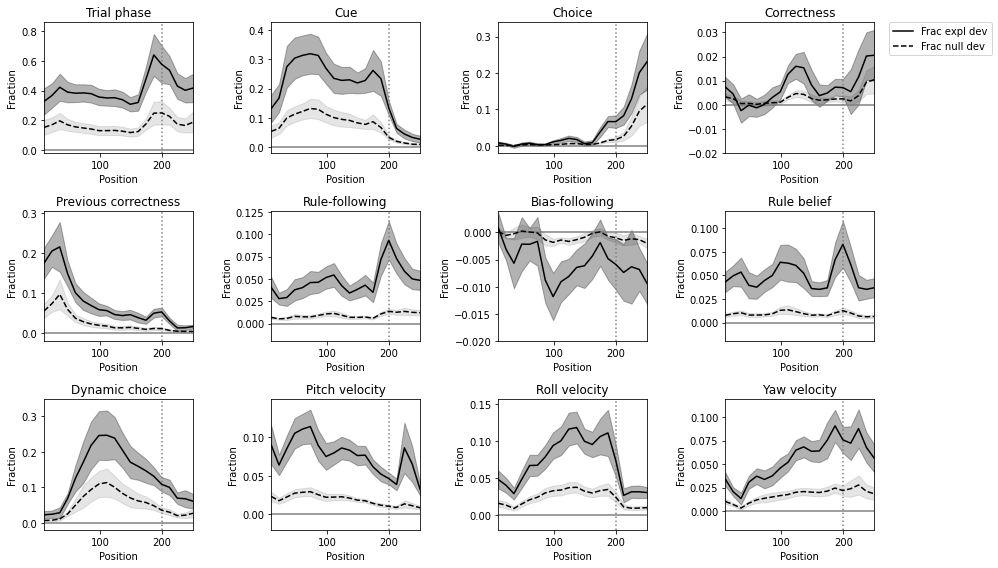

In [ ]:
# Plot fraction explained deviance and fraction null deviance during maze traversal
n_neurons = Y.shape[1]
fig, ax = plt.subplots(3,4,figsize=(14,8))
for i_var, this_name in enumerate(all_var):
    this_mean_expl = frac_expl_dev_pos[:,:,i_var].mean(axis=-1)
    this_sem_expl = frac_expl_dev_pos[:,:,i_var].std(axis=-1)/np.sqrt(n_neurons)
    this_mean_null = frac_null_dev_pos[:,:,i_var].mean(axis=-1)
    this_sem_null = frac_null_dev_pos[:,:,i_var].std(axis=-1)/np.sqrt(n_neurons)
    this_ax = ax[i_var//4,i_var%4]
    this_ax.plot(pos_centers, this_mean_expl,'k',label='Frac expl dev')
    this_ax.fill_between(pos_centers, this_mean_expl - this_sem_expl, this_mean_expl + this_sem_expl, color='k',alpha=0.3)
    this_ax.plot(pos_centers, this_mean_null,'k--',label='Frac null dev')
    this_ax.fill_between(pos_centers, this_mean_null - this_sem_null, this_mean_null + this_sem_null, color='k',alpha=0.1)
    this_ax.vlines(200, -0.02, 1.1*(this_mean_expl + this_sem_expl).max(), color='gray',ls=':')    
    this_ax.hlines(0, 10, 250, color='gray')    
    this_ax.set(xlabel='Position',ylabel='Fraction',title=group_name_pretty[i_var],
                ylim=[-0.02, 1.1*(this_mean_expl + this_sem_expl).max()],xlim=[10,250])
    if i_var == 3:
        this_ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

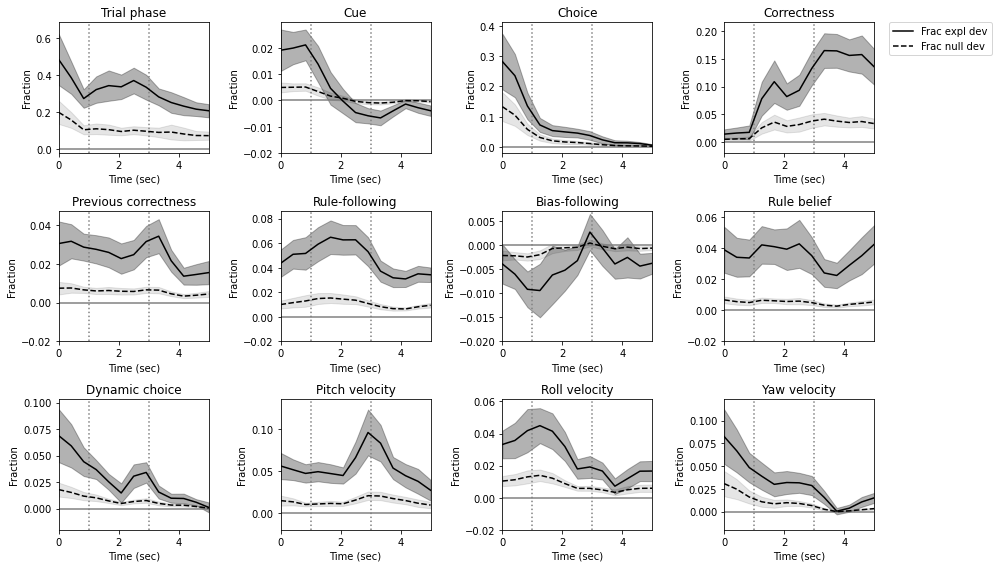

In [ ]:
# Plot fraction explained deviance and fraction null deviance in feedback/ITI
fig, ax = plt.subplots(3,4,figsize=(14,8))
for i_var, this_name in enumerate(all_var):
    this_mean_expl = frac_expl_dev_tm[:,:,i_var].mean(axis=-1)
    this_sem_expl = frac_expl_dev_tm[:,:,i_var].std(axis=-1)/np.sqrt(n_neurons)
    this_mean_null = frac_null_dev_tm[:,:,i_var].mean(axis=-1)
    this_sem_null = frac_null_dev_tm[:,:,i_var].std(axis=-1)/np.sqrt(n_neurons)
    this_ax = ax[i_var//4,i_var%4]
    this_ax.plot(tm_centers, this_mean_expl,'k',label='Frac expl dev')
    this_ax.fill_between(tm_centers, this_mean_expl - this_sem_expl, this_mean_expl + this_sem_expl, color='k',alpha=0.3)
    this_ax.plot(tm_centers, this_mean_null,'k--',label='Frac null dev')
    this_ax.fill_between(tm_centers, this_mean_null - this_sem_null, this_mean_null + this_sem_null, color='k',alpha=0.1)
    this_ax.vlines([1,3], -0.02, 1.1*(this_mean_expl + this_sem_expl).max(), color='gray',ls=':')
    this_ax.hlines(0, 0, 5, color='gray') 
    this_ax.set(xlabel='Time (sec)',ylabel='Fraction',title=group_name_pretty[i_var],
                ylim=[-0.02, 1.1*(this_mean_expl + this_sem_expl).max()],xlim=[0,5])
    if i_var == 3:
        this_ax.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()

Note that one issue of model breakdown procedure is that Poisson GLM has a non-linear activation function, so the "breakdown" is not linear. If you add the fraction explained deviance of all variables together, it will not sum to one. One should interpret this value from model breakdown procedure with caution. If you perform model breadown procedure on a Gaussian model, it will be linear and you don't need to worry about this issue.

Here I only demonstrate model breakdown procedure on individual variables. Similarly, one can perform model breakdown procedure on groups of variables. For example, one can ablate all features related to all three movement variables or all three strategy variables , and compute fraction null (or explained) deviance for "movement variables" or "strategy variables "as a whole. 

### Section 4.3: Model comparison procedure with re-fitting for feature contribution

Another commonly used method to evaluate contribution of a predictor is through refitting the model without that predictor and compare the model performance of the original model (**"full model"**) and the model fitted without that particular predictor (**"reduced model"**), which we called "model comparison" procedure. One can compute the **fraction null deviance** in this case, which is equivalent to the change in model performance (measured in fraction deviance explained). (You may compute fraction explained deviance by normalizing with the explained deviance of the full model, but computing fraction null deviance might be nore straightforward here.)

The schematic of the model comparison procedure is shown below:


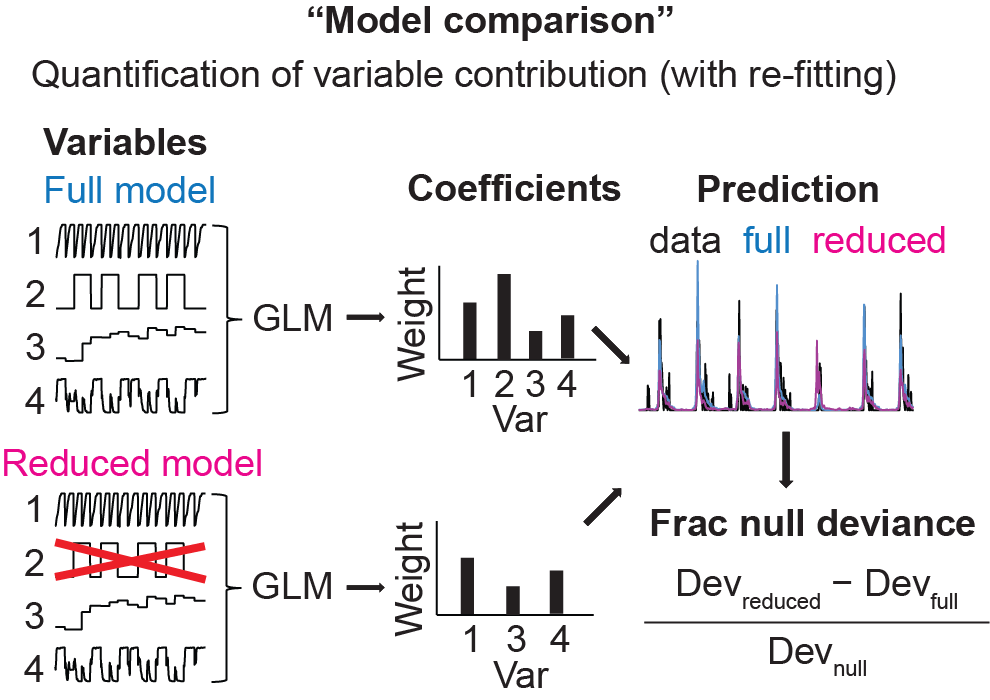

Because model comparison procedure requires re-fitting a model for each of the variables you want to evaluate on, here we only demonstrate model comparison procedure for cue as an example.

We first remove the features related to cue from the design matrix X_train to generate X_reduced, including the position and temporally expanded cue. We then split the data the same way as we did for the full model, and fit the reduced model with a newly initialized GLM_CV model, using the same CV splits as the full model. The previous GLM_CV for full model keeps the record of the `train_idx` and `val_idx` used during fitting, which we can extract and provide as inputs to the new model. 

In [ ]:
# Identify group index for position and time expanded cue
cue_fPos_ind = group_name.index('cue_fPos')
cue_choTm_ind = group_name.index('cue_choTm')

# Exclude cue from design matrix X to generate X_reduced
feature_to_keep_ind = np.ones_like(group_ind, dtype=bool)
feature_to_keep_ind[np.logical_or(group_ind == cue_fPos_ind, group_ind == cue_choTm_ind)] = False
X_reduced = X[:,feature_to_keep_ind]

# Exclude feature names with cue_fPos and cue_choTm
all_feature_names_reduced = [this_feature for i_feature, this_feature in enumerate(all_feature_names) if (group_ind[i_feature] != cue_fPos_ind and group_ind[i_feature] != cue_choTm_ind)]

print('Shape of X_reduced =', X_reduced.shape, '\nNumber of remaining features =', len(all_feature_names_reduced))

Shape of X_reduced = (27396, 285) 
Number of remaining features = 285


In [ ]:
# Split data the same way as full model into train and test set
X_train_reduced  = X_reduced [train_idx,:]
X_test_reduced  = X_reduced [test_idx,:]

# Re-compute group_size, group_name and group_ind for reduced model
group_size_reduced, group_name_reduced, group_ind_reduced = parse_group_from_feature_names(all_feature_names_reduced)

In [ ]:
## Initialize model
# Reset keras states
tf.keras.backend.clear_session()

# Initialize new GLM_CV 
# Here we set auto_split = False, so we can manually provide the same train-val split indices as the full model
model_cv_reduced = glm.GLM_CV(n_folds = 5, auto_split = False,
                              activation = 'exp', loss_type = 'poisson', 
                              regularization = 'group_lasso', lambda_series = 10.0 ** np.linspace(-1, -6, 11), 
                              optimizer = 'adam', learning_rate = 1e-2) 

In [ ]:
# Grab train-val split indices of each fold from the previously trained full model,
# so we can make sure to split the data the same way when training the reduced model
# Alternately, you can specify the "split_random_state" for both models at initiation
# to make sure the train-val split stays the same
train_idx_full_model = model_cv.train_idx
val_idx_full_model = model_cv.val_idx

# Fit the reduced model with train_idx and val_idx of the full model, and no need to provide group_idx since there's no auto-split 
model_cv_reduced.fit(X_train_reduced, Y_train, 
                     train_idx = train_idx_full_model, val_idx = val_idx_full_model,
                     feature_group_size = group_size_reduced, verbose = True) 

n_fold = 0
Lambda 0 iter 100 loss: 0.66015095 diff: 0.00343706
Lambda 0 iter 200 loss: 0.61153853 diff: 0.00048036
Lambda 0 iter 300 loss: 0.59905976 diff: 0.00012477
Lambda 0 iter 400 loss: 0.59481430 diff: 0.00004131
Lambda 0 iter 500 loss: 0.59328425 diff: 0.00001583
Lambda 0 iter 600 loss: 0.59243906 diff: 0.00000512
Lambda 0 iter 700 loss: 0.59197581 diff: 0.00000600
Lambda 0 iter 800 loss: 0.59203190 diff: 0.00000249
Lambda 0 iter 900 loss: 0.59197855 diff: 0.00000167
Fitting with Lambda 0 iter 1000 converged (loss diff = -0.00000096)
Lambda 1 iter 100 loss: 0.49166310 diff: 0.00038553
Lambda 1 iter 200 loss: 0.49150005 diff: 0.00000159
Fitting with Lambda 1 iter 300 converged (loss diff = -0.00000046)
Lambda 2 iter 100 loss: 0.41753483 diff: 0.00022734
Lambda 2 iter 200 loss: 0.41713074 diff: 0.00000398
Fitting with Lambda 2 iter 300 converged (loss diff = 0.00000086)
Lambda 3 iter 100 loss: 0.37229952 diff: 0.00009698
Lambda 3 iter 200 loss: 0.37181291 diff: 0.00000482
Fitting 

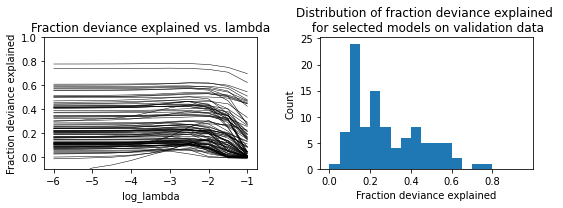

In [ ]:
# Perform model selection over regularization for the reduced model
model_cv_reduced.select_model(se_fraction = 0., min_lambda = 0., make_fig = True)

Fraction deviance explained: mean = 0.2781, median = 0.2360


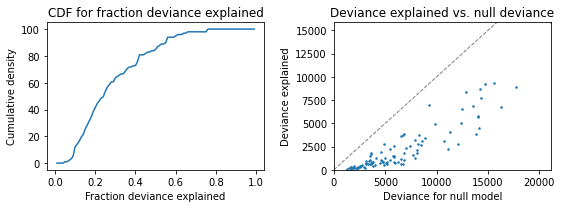

In [ ]:
# Evalute the mean fraction deviance explained for each neuron in the reduced model
frac_dev_expl_reduced, _, _, _ = model_cv_reduced.evaluate(X_test_reduced, Y_test, make_fig = True)

After model fitting, selection and evaluation for the reduced model, we can compare the overall model performance (fraction deviance explained) on test data of the full model and reduced model when cue is removed from fitting. We can see that for almost all neurons, we get a reduction in model performance, indicating that cue contributed to the activity of those neurons.

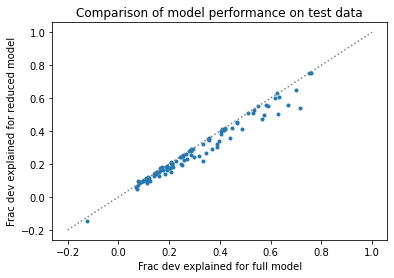

In [ ]:
# Compare model performance of full vs. reduced model
plt.plot(frac_dev_expl, frac_dev_expl_reduced, '.')
plt.plot([-0.2,1],[-0.2,1],'gray',ls=':')
plt.xlabel('Frac dev explained for full model')
plt.ylabel('Frac dev explained for reduced model')
plt.title('Comparison of model performance on test data');

We can also compute the position and time binned fraction null deviance of cue by comparing the full model and reduced model. Same as the model breakdown procedure, here we evaluate the fraction null deviance on CV held-out data, which is 85% of the whole dataset.

In [ ]:
# Make prediction of reduced model on CV held-out data
pred_reduced_cv = model_cv_reduced.make_prediction_cv(X_train_reduced)

# Compute the pointwise model deviance of the reduced model
model_dev_reduced = glm.pointwise_deviance(Y[train_idx,:], pred_reduced_cv, loss_type = model_cv_reduced.loss_type)

# Bin model deviance for reduced model into position and time bins
model_dev_pos_reduced, model_dev_tm_reduced = pos_tm_binning(model_dev_reduced, posF_train, time_from_cho_train, 
                                                             pos_centers, pos_half_width, tm_centers, tm_half_width)
print(model_dev_reduced.shape, model_dev_pos_reduced.shape, model_dev_tm_reduced.shape)

# Compute differences in model deviance for full and reduced model and then normalize by average null deviance 
# i.e. "fraction null deviance" for model comparison
diff_frac_null_dev_pos = (model_dev_pos_reduced - model_dev_pos)/null_dev_avg[np.newaxis,:]
diff_frac_null_dev_tm = (model_dev_tm_reduced - model_dev_tm)/null_dev_avg[np.newaxis,:]

(23263, 100) (20, 100) (13, 100)


Now we can visualize the position and time binned fraction null deviance of cue from the model comparison procedure, and compare it to that from model breakdown procedure.

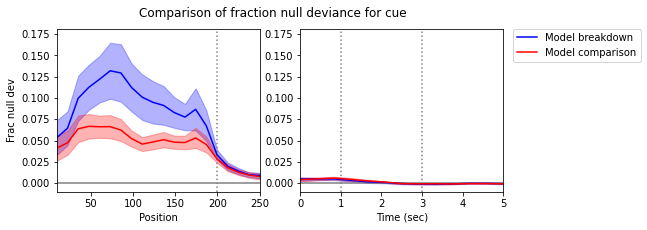

In [ ]:
## Compare fraction null deviance of cue for model breakdwon vs. model comparison procedure
cue_ind = all_var.index('cue')
fig, ax = plt.subplots(1,2,figsize=(8,3)) 

# Plot maze traversal
this_mean_pos_mb = frac_null_dev_pos[:,:,cue_ind].mean(axis=-1)
this_sem_pos_mb = frac_null_dev_pos[:,:,cue_ind].std(axis=-1)/np.sqrt(n_neurons)
this_mean_pos_mc = diff_frac_null_dev_pos.mean(axis=-1)
this_sem_pos_mc = diff_frac_null_dev_pos.std(axis=-1)/np.sqrt(n_neurons)
ax[0].plot(pos_centers, this_mean_pos_mb, 'b')
ax[0].fill_between(pos_centers, this_mean_pos_mb - this_sem_pos_mb, this_mean_pos_mb + this_sem_pos_mb, color='b',alpha=0.3)
ax[0].plot(pos_centers, this_mean_pos_mc, 'r')
ax[0].fill_between(pos_centers, this_mean_pos_mc - this_sem_pos_mc, this_mean_pos_mc + this_sem_pos_mc, color='r',alpha=0.3)
ax[0].vlines(200, -0.01, 1.1*(this_mean_pos_mb + this_sem_pos_mb).max(), color='gray', ls=':')
ax[0].hlines(0, 10, 250, color='gray')
ax[0].set(xlabel='Position', ylabel='Frac null dev',
          ylim=[-0.01, 1.1*(this_mean_pos_mb + this_sem_pos_mb).max()], xlim=[10,250])

# Plot feedback/ITI
this_mean_tm_mb = frac_null_dev_tm[:,:,cue_ind].mean(axis=-1)
this_sem_tm_mb = frac_null_dev_tm[:,:,cue_ind].std(axis=-1)/np.sqrt(n_neurons)
this_mean_tm_mc = diff_frac_null_dev_tm.mean(axis=-1)
this_sem_tm_mc = diff_frac_null_dev_tm.std(axis=-1)/np.sqrt(n_neurons)
ax[1].plot(tm_centers, this_mean_tm_mb, 'b', label='Model breakdown')
ax[1].fill_between(tm_centers, this_mean_tm_mb - this_sem_tm_mb, this_mean_tm_mb + this_sem_tm_mb, color='b',alpha=0.3)
ax[1].plot(tm_centers, this_mean_tm_mc, 'r', label='Model comparison')
ax[1].fill_between(tm_centers, this_mean_tm_mc - this_sem_tm_mc, this_mean_tm_mc + this_sem_tm_mc, color='r',alpha=0.3)
ax[1].vlines([1,3], -0.01, 1.1*(this_mean_pos_mb + this_sem_pos_mb).max(), color='gray', ls=':')
ax[1].hlines(0, 0, 5, color='gray')
ax[1].set(xlabel='Time (sec)', ylabel='',
          ylim=[-0.01, 1.1*(this_mean_pos_mb + this_sem_pos_mb).max()], xlim=[0,5])
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

fig.suptitle('Comparison of fraction null deviance for cue');

Strikingly, we can see that the magnitude of fraction null deviance from model comparison procedure appears to be much smaller than that from model breakdown procedure. One reason can be as mentioned before, model breakdown procedure is not linear for Poisson GLMs. However, another major reason is that, model comparison procedure extracts the "unique" portion of variability accounted by the variable we remove, allowing the re-fitted model to re-adjust its weights to the remaining variables. When there are correlated variables in the design matrix, which is almost always the case for neural recording with behavioral tasks, the refitted model can use re-adjust its weights for the correlated variables and use them to explain response variability. Therefore, the contribution of the variable removed from the refitted model will shrink, even if we don't know which variable is the actual one modulating neural activity. Model breakdown procedure, on the other hand, prevents model from re-adjusting their weights and is more likely to assign contributions in a more unbiased way, assuming the model is not mis-specified too terribly. It is everyone's choice to select the method and report what they consider reasonable in a case-by-case scenario.

(You may ask, what variable in this case is correlated with cue that can absorbed its contribution to neural activity during refitting? Well, surprisingly, or maybe not that surprising, during this behavioral task, the mice tended to embody the cue identity into their running patterns, i.e., they ran differently on trials with black cue vs. white cue. Therefore, the running velocities became somehow correlated with cue identity. Similarly, there are usually many correlated variables that we record from these types of experiments, even if it's not obvious or incentivized in the first place.)



### Section 4.4: Comparison of methods

To wrap up, it is everyone's choice of to use these three methods. Here is a summary of the pros and cons of each method. But overall, these methods are complementary to each other, and should give you consistent results in qualitative ways.

**Model weights**:
- Should be interpreted as "multiplicative factors" of neural activity
- Provide information for both magnitude and directionality of tuning
- Robust to differences in baseline response
- Difficult to interpret the magnitude when comparing across variables

**Model breakdown procedure (for fraction null deviance and fraction explained deviance)**:
- The metrics are easy to interpret and compare across variables
- Does not tell you the directionality of tuning
- Does not require re-fitting the model (fast to do)
- It's not a linear breakdown for Poisson GLMs, but linear for Gaussian
- Can be less biased in assigning contribution of correlated variables, if the model is not terribly mis-specified

**Model comparison procedure with re-fitting (for fraction null deviance)**:
- The metric is easy to interpret and compare across variables
- Does not tell you the directionality of tuning
- Require re-fitting of a model for each variable (computationally demanding)
- Extract the "unique" portion of deviance explained, can be biased (and underestimate the contribution of a variable) when there are correlated variables and you don't know which is actually contributing to response

## References


- Tseng, S.-Y., Chettih, S.N., Arlt, C., Barroso-Luque, R., and Harvey, C.D. (2022). Shared and specialized coding across posterior cortical areas for dynamic navigation decisions. Neuron 110, 2484–2502.e16.

- Minderer, M., Brown, K.D., and Harvey, C.D. (2019). The spatial structure of neural encoding in mouse posterior cortex during navigation. Neuron 102, 232–248.e11.

- Pillow, J.W., Shlens, J., Paninski, L., Sher, A., Litke, A.M., Chichilnisky, E.J., and Simoncelli, E.P. (2008). Spatio-temporal correlations and visual signalling in a complete neuronal population. Nature 454, 995–999.